In [1]:
import re
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
node = []
allDatas = []
siganlList = []
SignalsName = []
messageName = []

In [2]:
def readFile(file_name):
    global node,allDatas,siganlList,SignalsName,messageName
    ''' 得到dbc文件的绝对路径'''
    filePath = file_name
    if filePath:
        print(filePath)
        f = open(filePath, "r")  # 设置文件对象
    else:
        print("读取文件失败！")
        return 0
    """
    NodesPattern:节点
    MessagePattern：消息
    SignalPattern：信号
    """
    NodesPattern = re.compile(r"BU_: (.*)", re.S)
    MessagePattern = re.compile(r"BO_ (.*?) (.*?): (.*?) (.*)", re.S)
#     SignalPattern = re.compile('''SG_ (.*?) : (.*?)\|(.*?)@.*? \((.*?),(.*?)\) \[(.*?)\|(.*?)\] "(.*?)" (.*)''', re.S)
    SignalPattern = re.compile('''SG_ (.*?) : (.*?)\|(.*?)@([0-9])([+|-]) \((.*?),(.*?)\) \[(.*?)\|(.*?)\] "(.*?)" (.*)''', re.S)
    DefaultValue = '''BA_ "GenSig(.*?)" SG_ (\d+) signalname (\d+);'''

    line = f.readline()
    allDatas=[]
    while line:
        """ 匹配出节点 """
        NodesSearched = re.search(NodesPattern, line.strip())
        if NodesSearched:
            node = NodesSearched.group(1).split(" ")
            #print(node)
        """ 匹配出消息 """
        MessageSearched = re.search(MessagePattern, line.strip())
        if MessageSearched:
            siganlList.clear()
            """如果匹配到了message，则获取到message的相关参数 
             比如匹配到了NM_Message_ESC_409，则会解析出改message的一些参数构成list对象['1033', 'NM_Message_ESC_409', '8', 'ESC']
             这四个参数分别是 messgage ID ;message name ; messgae dataLenth ,message sender
             而且把这个list对象 加在了 siganlList 索引0的位置
            """
            Message = list(MessageSearched.groups())
            siganlList.append(Message)
            """ 只 要 message的名字 messageName 列表中"""
            messageName.append(Message[1])
            """读取下一行"""
            line = f.readline()
            """因为有些message并没有定义signal，所以 下一行还是message"""
            MessageSearched = re.search(MessagePattern, line.strip())
            SignalSearched = re.search(SignalPattern, line.strip())
            """下一行如果不是message的内容 就一定是signal的内容了"""
            if not MessageSearched:
                while SignalSearched:
                    """获取信号的参数追加到siganlList"""
                    signal = list(SignalSearched.groups())
                    siganlList.append(signal)
                    """只获取 signal name"""
                    SignalsName.append(signal[0])

                    # 再次解析信号，直到这个message下的信号全部解析完毕
                    line = f.readline()
                    SignalSearched = re.search(SignalPattern, line.strip())
           # print(siganlList)
            c = copy.deepcopy(siganlList)
            allDatas.append(c)
        else:
            line = f.readline()
            MessageSearched = re.search(MessagePattern, line.strip())
    f.close()  # 将文件关闭
    return 1

In [3]:
import os
file_names = []
path = os.path.abspath('../My_DBC')
# path = os.path.abspath('./opendbc-master/opendbc-master')
dirs = os.listdir(path)                    # 获取指定路径下的文件
for i in dirs:
    if os.path.splitext(i)[1] == ".dbc":
        file_names.append(os.path.join(path,i))
file_names

['D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\cadillac_ct6_object.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\cadillac_ct6_powertrain.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\gm_global_a_powertrain.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\honda_civic_hatchback_ex_2017_can_generated.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\honda_civic_sedan_16_diesel_2019_can_generated.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\honda_civic_touring_2016_can_generated.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\tesla_can.dbc',
 'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\tesla_powertrain.dbc',
 'D:\\--storage-

In [4]:
file_name = file_names[3]
file_name

'D:\\--storage--\\program\\Code\\jupyter-notebook\\CarNetworkIDS\\Code\\MyTask\\My_DBC\\honda_civic_hatchback_ex_2017_can_generated.dbc'

In [5]:
readFile(file_name)

D:\--storage--\program\Code\jupyter-notebook\CarNetworkIDS\Code\MyTask\My_DBC\honda_civic_hatchback_ex_2017_can_generated.dbc


1

In [6]:
data_gts = {}
for alldata in allDatas:
#     print(str(hex(int(alldata[0][0]))))
#     print(str(hex(int(alldata[0][0])))[2:])
    data_gts[str(hex(int(alldata[0][0])))[2:]] = alldata

In [7]:
all_id_lsbs = {}
for k in data_gts.keys():
    message = data_gts[k]
    lsb_list = []
    series = np.zeros(64)
    message_id = message[0][0]+"_"+message[0][1]
    del message[0]
    for signal in message:
        start = int(signal[1])
        length = int(signal[2])
        endianness = int(signal[3])
        start_row = int(start / 8)
        start_col = 8 - (start - start_row * 8) - 1
        new_start = start_row * 8 + start_col
        if endianness == 0:
            new_end = new_start + length
            cur_lsb = new_end - 1
        if endianness == 1:
            cur_lsb = new_start
        lsb_list.append(cur_lsb)
    all_id_lsbs[k] = lsb_list
all_id_lsbs

{'94': [9, 39, 63, 59],
 'e4': [16, 23, 31, 15, 35, 39],
 'e5': [7, 15, 23, 31, 59, 63],
 'e8': [13, 47, 26, 51, 55],
 '14a': [15, 31, 37, 38, 39, 55, 59, 63],
 '158': [15, 31, 47, 55, 59, 63],
 '17c': [7, 31, 32, 33, 38, 39, 49, 50, 55, 59, 63],
 '18f': [15, 31, 35, 36, 47, 51, 55],
 '1a4': [27, 15, 41, 42, 59, 63],
 '1ab': [0, 15, 17, 19, 23],
 '1c2': [4, 27, 59, 63],
 '1d0': [14, 29, 44, 59, 63],
 '1df': [23, 18, 15, 34, 57, 37, 36, 35, 38, 40, 44, 59, 63],
 '1ea': [15, 31, 59, 63],
 '1ef': [31, 39, 23, 55, 15, 7, 0, 63, 59],
 '221': [16, 35, 43, 47],
 '240': [40, 46, 27, 11, 15, 59, 63],
 '241': [55, 10, 9, 27, 43, 3, 59, 63],
 '243': [40, 46, 27, 11, 15, 59, 63],
 '244': [55, 10, 9, 27, 43, 3, 59, 63],
 '246': [40, 46, 27, 11, 15, 59, 63],
 '247': [55, 10, 9, 27, 43, 3, 59, 63],
 '249': [40, 46, 27, 11, 15, 59, 63],
 '24a': [55, 10, 9, 27, 43, 3, 59, 63],
 '255': [7, 15, 23, 31, 39, 47, 55, 63, 59],
 '296': [2, 5, 27, 31],
 '305': [0, 13, 12, 11, 10, 9, 8, 51, 55],
 '309': [23, 15

In [8]:
all_id_labels = {}
for k in all_id_lsbs:
    cur_lsb_list = all_id_lsbs[k]
    cur_label = np.zeros(64)
    for cur_lsb in cur_lsb_list:
        cur_label[cur_lsb] = 1
    all_id_labels[k] = cur_label
all_id_labels

{'94': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]),
 'e4': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'e5': array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.]),
 'e8': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.

In [9]:
data = pd.read_csv('../../../DataMessage/Honda/honda001.csv')
data["bin"] = data["Data"].apply(int, base=16).apply(bin).str[2:].apply(lambda x: x.zfill(64))
group = data.groupby(by="ID")
id_tracelist = data["bin"].apply(lambda x: list(x)).tolist()
id_tracedict = {}
for trace in list(group):
    id_tracedict[trace[0]] = trace[1]["bin"].apply(lambda x: list(x)).tolist()

In [10]:
data.shape

(1509141, 4)

In [11]:
data.iloc[0,]

Timestamp                                            144558902
ID                                                          39
Data                                                    00002a
bin          0000000000000000000000000000000000000000000000...
Name: 0, dtype: object

In [12]:
id_tracedict['1d0']

[['0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '1',
  '0'],
 ['0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '1',
  '0'],
 ['0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0

In [13]:
list(group)

[('13c',
           Timestamp   ID              Data  \
  7        144558904  13c  007c007a0000043d   
  22       144558914  13c  007c007a00000400   
  43       144558924  13c  007c007a0000041f   
  62       144558934  13c  007a007a00000420   
  80       144558944  13c  007a007a0000043f   
  ...            ...  ...               ...   
  1509073  150142943  13c  00fa00fb1d000412   
  1509084  150142953  13c  00fa00fb1d000421   
  1509102  150142963  13c  00fb00fb1d00043f   
  1509112  150142973  13c  00fb00fb1d000402   
  1509133  150142983  13c  00fa00fc1d000411   
  
                                                         bin  
  7        0000000001111100000000000111101000000000000000...  
  22       0000000001111100000000000111101000000000000000...  
  43       0000000001111100000000000111101000000000000000...  
  62       0000000001111010000000000111101000000000000000...  
  80       0000000001111010000000000111101000000000000000...  
  ...                                         

<BarContainer object of 64 artists>

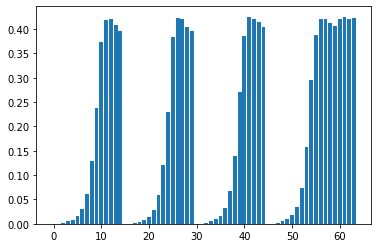

In [14]:
# 使用READ方法计算bit-flip
# 130
# 135
# 140
# 148
# 160
# 362
# 4c1
# 4c5
# 4c9
# 4d1
# 514
# 52a
# 530
# 780
idname = '1d0'
messagelist = id_tracedict[idname]
trace_len = len(messagelist)
bit_flip = np.zeros(64)
previous = messagelist[0]
for item in messagelist:
    for ix in range(64):
        if item[ix] != previous[ix]:
            bit_flip[ix] = bit_flip[ix] + 1
    previous = item
for ix in range(64):
    bit_flip[ix] = bit_flip[ix] / trace_len
fig = plt.figure(facecolor = "white")
plt.bar(range(len(bit_flip)), bit_flip)

### 1.获得大端数据，并计算大端的比特翻转率和比特翻转联合概率

<BarContainer object of 66 artists>

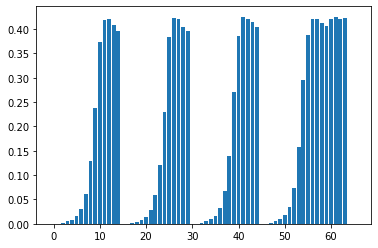

In [15]:
# 使用READ方法计算bit-flip
bit_flip_dict = {}
for id in id_tracedict.keys():
    messagelist = id_tracedict[id]
    trace_len = len(messagelist)
    bit_flip = np.zeros(64)
    previous = messagelist[0]
    for item in messagelist:
        for ix in range(64):
            if item[ix] != previous[ix]:
                bit_flip[ix] = bit_flip[ix] + 1
        previous = item
    for ix in range(64):
        bit_flip[ix] = bit_flip[ix] / trace_len
    
    bit_flip = np.append(bit_flip, 0)
    bit_flip = np.append(bit_flip, 0)
    
    bit_flip_dict[id] = bit_flip
fig = plt.figure(facecolor = "white")
plt.bar(range(len(bit_flip_dict[idname])), bit_flip_dict[idname])

In [16]:
bit_flip_list = []
for id in bit_flip_dict.keys():
    bit_flip_list.append(bit_flip_dict[id])

In [17]:
bit_flip_list_df = pd.DataFrame(bit_flip_list)

In [18]:
bit_flip_list_df

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,0.000720,0.000720,0.000720,0.000720,0.000720,0.000720,0.001885,0.004322,0.010900,0.020168,...,0.000000,0.000000,0.499995,0.999989,0.264165,0.433241,0.497188,0.675522,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.499989,0.999989,0.351130,0.488623,0.498210,0.567512,0.0,0.0
2,0.000000,0.000000,0.000032,0.000413,0.001229,0.003114,0.006175,0.011143,0.021217,0.042497,...,0.000000,0.000000,0.499995,0.999989,0.456322,0.498872,0.498777,0.580773,0.0,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.499995,0.999989,0.500005,0.500005,0.499995,0.999989,0.0,0.0
4,0.000000,0.000127,0.000890,0.001621,0.003443,0.007002,0.013834,0.026110,0.000000,0.000064,...,0.000000,0.000000,0.499995,0.999989,0.268084,0.427172,0.498819,0.752031,0.0,0.0
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.499989,0.999989,0.362874,0.459122,0.494248,0.724317,0.0,0.0
6,0.000000,0.000000,0.000000,0.000000,0.000011,0.000021,0.000021,0.000011,0.000000,0.000000,...,0.000000,0.000000,0.499995,0.999989,0.288549,0.402015,0.498300,0.940407,0.0,0.0
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.499995,0.999989,0.447274,0.457824,0.502378,0.604854,0.0,0.0
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000042,0.001610,0.001695,...,0.000000,0.000000,0.499979,0.999979,0.021525,0.486441,0.500508,0.666582,0.0,0.0
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000021,0.000000,0.000000,0.000000,0.000000,...,0.000021,0.000000,0.499989,0.999979,0.232597,0.408421,0.501430,0.723601,0.0,0.0


<BarContainer object of 66 artists>

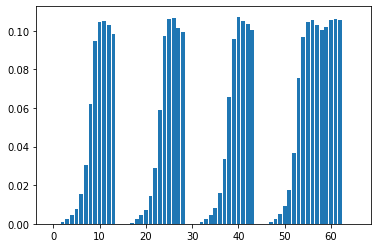

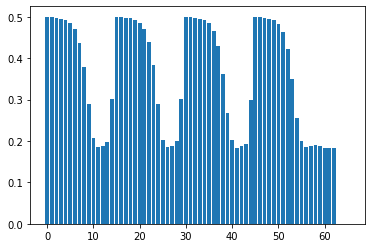

In [19]:
# 使用READ方法计算bit-flip的联合概率
bit_flip_LH_dict = {}
bit_flip_LH_no_dict = {}
for id in id_tracedict.keys():
    messagelist = id_tracedict[id]
    bit_flip_LH = np.zeros(64)
    bit_flip_LH_no = np.zeros(64)
    previous_LH = messagelist[0]
    for item in messagelist:
        for ix in range(63):
            if item[ix] != previous_LH[ix] and item[ix+1] != previous_LH[ix+1]:
                bit_flip_LH[ix] = bit_flip_LH[ix] + 1
            if item[ix] == previous_LH[ix] and item[ix+1] == previous_LH[ix+1]:
                bit_flip_LH_no[ix] = bit_flip_LH_no[ix] + 1
        previous_LH = item
    for ix in range(63):
        bit_flip_LH[ix] = bit_flip_LH[ix] / trace_len
        bit_flip_LH_no[ix] = bit_flip_LH_no[ix] / trace_len
        
    bit_flip_LH = np.append(bit_flip_LH, 0)
    bit_flip_LH = np.append(bit_flip_LH, 0)
    bit_flip_LH_no = np.append(bit_flip_LH_no, 0)
    bit_flip_LH_no = np.append(bit_flip_LH_no, 0)

    bit_flip_LH_dict[id] = bit_flip_LH
    bit_flip_LH_no_dict[id] = bit_flip_LH_no
    
fig = plt.figure(facecolor = "white")
plt.bar(range(len(bit_flip_LH_dict[idname])), bit_flip_LH_dict[idname])
fig = plt.figure(facecolor = "white")
plt.bar(range(len(bit_flip_LH_no_dict[idname])), bit_flip_LH_no_dict[idname])

### 2.获得小端数据，并计算小端的比特翻转率和比特翻转联合概率

In [14]:
# reverse_id_tracelist
reverse_id_tracedict = {}
for id in id_tracedict.keys():
    id_tracelist = id_tracedict[id]
    reverse_id_tracelist = []
    for item in id_tracelist:
        cur_tracelist = [0,1,2,3,4,5,6,7]
        cur_temp = []
        count = 7
        for i in range(64):
            cur_temp.append(item[i])
            if (i+1)%8 == 0:
                cur_tracelist[count] = cur_temp
                count = count - 1
                cur_temp = []
        reverse_id_tracelist.append(np.concatenate(cur_tracelist).tolist())
    reverse_id_tracedict[id] = reverse_id_tracelist
reverse_id_tracedict[idname]

[['0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0'],
 ['0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0'],
 ['0',
  '0',
  '0',
  '0',
  '1',
  '0',
  '1',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0',
  '0

<BarContainer object of 66 artists>

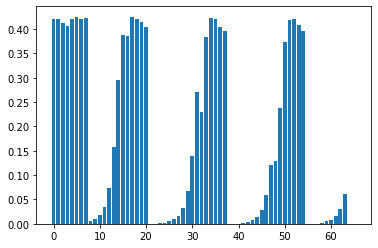

In [15]:
# 使用READ方法计算bit-flip
reverse_bit_flip_dict = {}
for id in reverse_id_tracedict.keys():
    reverse_messagelist = reverse_id_tracedict[id]
    reverse_trace_len = len(reverse_messagelist)
    reverse_bit_flip = np.zeros(64)
    reverse_previous = reverse_messagelist[0]
    for item in reverse_messagelist:
        for ix in range(64):
            if item[ix] != reverse_previous[ix]:
                reverse_bit_flip[ix] = reverse_bit_flip[ix] + 1
        reverse_previous = item
    for ix in range(64):
        reverse_bit_flip[ix] = reverse_bit_flip[ix] / reverse_trace_len
    
    reverse_bit_flip = np.append(reverse_bit_flip, 0)
    reverse_bit_flip = np.append(reverse_bit_flip, 0)
    
    reverse_bit_flip_dict[id] = reverse_bit_flip
fig = plt.figure(facecolor = "white")
plt.bar(range(len(reverse_bit_flip_dict[idname])), reverse_bit_flip_dict[idname])

<BarContainer object of 66 artists>

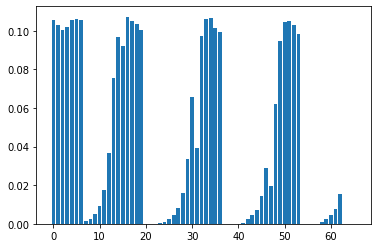

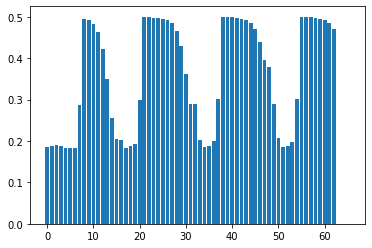

In [16]:
# 使用READ方法计算bit-flip的联合概率
reverse_bit_flip_LH_dict = {}
reverse_bit_flip_LH_no_dict = {}
for id in reverse_id_tracedict.keys():
    reverse_messagelist = reverse_id_tracedict[id]
    reverse_bit_flip_LH = np.zeros(64)
    reverse_bit_flip_LH_no = np.zeros(64)
    reverse_previous_LH = reverse_messagelist[0]
    for item in reverse_messagelist:
        for ix in range(63):
            if item[ix] != reverse_previous_LH[ix] and item[ix+1] != reverse_previous_LH[ix+1]:
                reverse_bit_flip_LH[ix] = reverse_bit_flip_LH[ix] + 1
            if item[ix] == reverse_previous_LH[ix] and item[ix+1] == reverse_previous_LH[ix+1]:
                reverse_bit_flip_LH_no[ix] = reverse_bit_flip_LH_no[ix] + 1
        reverse_previous_LH = item
    for ix in range(63):
        reverse_bit_flip_LH[ix] = reverse_bit_flip_LH[ix] / trace_len
        reverse_bit_flip_LH_no[ix] = reverse_bit_flip_LH_no[ix] / trace_len
        
    reverse_bit_flip_LH = np.append(reverse_bit_flip_LH, 0)
    reverse_bit_flip_LH = np.append(reverse_bit_flip_LH, 0)
    reverse_bit_flip_LH_no = np.append(reverse_bit_flip_LH_no, 0)
    reverse_bit_flip_LH_no = np.append(reverse_bit_flip_LH_no, 0)

    reverse_bit_flip_LH_dict[id] = reverse_bit_flip_LH
    reverse_bit_flip_LH_no_dict[id] = reverse_bit_flip_LH_no
    
fig = plt.figure(facecolor = "white")
plt.bar(range(len(reverse_bit_flip_LH_dict[idname])), reverse_bit_flip_LH_dict[idname])
fig = plt.figure(facecolor = "white")
plt.bar(range(len(reverse_bit_flip_LH_no_dict[idname])), reverse_bit_flip_LH_no_dict[idname])

<BarContainer object of 64 artists>

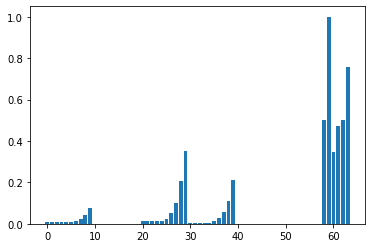

In [17]:
# 小端转成大端的正常格式，方便与上边生成的ground truth label匹配
reverse_id_tracelist = []
item = reverse_bit_flip
cur_tracelist = [0,1,2,3,4,5,6,7]
cur_temp = []
count = 7
for i in range(64):
    cur_temp.append(item[i])
    if (i+1)%8 == 0:
        cur_tracelist[count] = cur_temp
        count = count - 1
        cur_temp = []
fig = plt.figure(facecolor = "white")
plt.bar(range(len(np.concatenate(cur_tracelist).tolist())), np.concatenate(cur_tracelist).tolist())

### 3.先不去掉常数位，实现CAN-D

In [18]:
def get_reverse_sub_feature(ix, id):
    f1 = reverse_bit_flip_dict[id][ix]
    f2 = reverse_bit_flip_LH_dict[id][ix] / reverse_bit_flip_dict[id][ix+1]
    f3 = reverse_bit_flip_LH_dict[id][ix] / reverse_bit_flip_dict[id][ix]
    f4 = reverse_bit_flip_LH_no_dict[id][ix] / (1 - reverse_bit_flip_dict[id][ix+1])
    f5 = reverse_bit_flip_LH_no_dict[id][ix] / (1 - reverse_bit_flip_dict[id][ix])
    return np.array([f1,f2,f3,f4,f5])

def get_sub_feature(ix, id):
    f1 = bit_flip_dict[id][ix]
    f2 = bit_flip_LH_dict[id][ix] / bit_flip_dict[id][ix+1]
    f3 = bit_flip_LH_dict[id][ix] / bit_flip_dict[id][ix]
    f4 = bit_flip_LH_no_dict[id][ix] / (1 - bit_flip_dict[id][ix+1])
    f5 = bit_flip_LH_no_dict[id][ix] / (1 - bit_flip_dict[id][ix])
    return np.array([f1,f2,f3,f4,f5])

In [19]:
def get_reverse_feature(ix, id):
    reverse_cur_bit_feature = []
    reverse_feature_sub1 = get_reverse_sub_feature(ix, id)
    reverse_feature_sub2 = get_reverse_sub_feature(ix+1, id)
    reverse_feature_sub3 = reverse_feature_sub2 - reverse_feature_sub1
    return np.concatenate((reverse_feature_sub1,reverse_feature_sub2,reverse_feature_sub3))

def get_feature(ix, id):
    cur_bit_feature = []
    feature_sub1 = get_sub_feature(ix, id)
    feature_sub2 = get_sub_feature(ix+1, id)
    feature_sub3 = feature_sub2 - feature_sub1
    return np.concatenate((feature_sub1,feature_sub2,feature_sub3))

In [20]:
# 大端
bit_features_dict = {}
for id in bit_flip_dict.keys():
    bit_features = []
    for ix in range(64):
        bit_features.append(get_feature(ix, id))
    bit_features_dict[id] = bit_features
bit_features_dict[idname]

C:\Users\Linever\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Linever\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


[array([ 0.00000000e+00,  0.00000000e+00,             nan,  5.00000000e-01,
         4.99989407e-01,  2.11855430e-05,  4.76190476e-03,  5.00000000e-01,
         5.00000000e-01,  4.98898328e-01,  2.11855430e-05,  4.76190476e-03,
                    nan,  0.00000000e+00, -1.09107880e-03]),
 array([ 2.11855430e-05,  4.76190476e-03,  5.00000000e-01,  5.00000000e-01,
         4.98898328e-01,  2.22448201e-03,  2.34375000e-01,  5.00000000e-01,
         5.00000000e-01,  4.98736650e-01,  2.20329647e-03,  2.29613095e-01,
         0.00000000e+00,  0.00000000e+00, -1.61678532e-04]),
 array([ 0.00222448,  0.234375  ,  0.5       ,  0.5       ,  0.49873665,
         0.00474556,  0.27317073,  0.5       ,  0.5       ,  0.49802035,
         0.00252108,  0.03879573,  0.        ,  0.        , -0.0007163 ]),
 array([ 0.00474556,  0.27317073,  0.5       ,  0.5       ,  0.49802035,
         0.00868607,  0.27891156,  0.5       ,  0.5       ,  0.49652718,
         0.00394051,  0.00574083,  0.        ,  0.     

In [21]:
alldatas_msb = []
alllabels_msb = []
for id in bit_features_dict.keys():
    if(bit_features_dict.__contains__(id) and all_id_labels.__contains__(id)):
        cur_features = bit_features_dict[id]
        cur_labels = all_id_labels[id]
        for i in range(64):
            alldatas_msb.append(cur_features[i])
            alllabels_msb.append(int(cur_labels[i]))
    else:
        print(id)

13c
156
161
18e
19b
1a6
1aa
1dc
1ed
21e
294
295
320
328
372
377
378
386
39
3d7
3d9
400
403
406
40c
40f
428
42d
42e
454
465
555
91


In [ ]:
# 小端
reverse_bit_features_dict = {}
for id in reverse_bit_flip_dict.keys():
    reverse_bit_features = []
    for ix in range(64):
        reverse_bit_features.append(get_reverse_feature(ix, id))
    reverse_bit_features_dict[id] = reverse_bit_features
reverse_bit_features_dict[idname]

In [21]:
# 小端转成大端的正常格式，方便与上边生成的ground truth label匹配
bit_features_dict = {}
for id in reverse_bit_features_dict.keys():
    item = reverse_bit_features_dict[id]
    cur_bit_features = [0,1,2,3,4,5,6,7]
    cur_temp = []
    count = 7
    for i in range(64):
        cur_temp.append(item[i])
        if (i+1)%8 == 0:
            cur_bit_features[count] = cur_temp
            count = count - 1
            cur_temp = []
    bit_features_dict[id] = np.concatenate(cur_bit_features).tolist()
bit_features_dict[idname]

[[0.0,
  0.0,
  nan,
  0.5,
  0.49998940722850727,
  2.1185542985466717e-05,
  0.004761904761904762,
  0.5,
  0.5,
  0.49889832842524523,
  2.1185542985466717e-05,
  0.004761904761904762,
  nan,
  0.0,
  -0.0010910788032620355],
 [2.1185542985466717e-05,
  0.004761904761904762,
  0.5,
  0.5,
  0.49889832842524523,
  0.002224482013474005,
  0.23437499999999997,
  0.5,
  0.5,
  0.4987366498927745,
  0.0022032964704885383,
  0.2296130952380952,
  0.0,
  0.0,
  -0.0001616785324707326],
 [0.002224482013474005,
  0.23437499999999997,
  0.5,
  0.5,
  0.4987366498927745,
  0.004745561628744545,
  0.2731707317073171,
  0.5,
  0.5,
  0.49802034995104094,
  0.0025210796152705397,
  0.03879573170731712,
  0.0,
  0.0,
  -0.0007162999417335558],
 [0.004745561628744545,
  0.2731707317073171,
  0.5,
  0.5,
  0.49802034995104094,
  0.008686072624041355,
  0.27891156462585037,
  0.5,
  0.5,
  0.49652718413403996,
  0.00394051099529681,
  0.0057408329185332785,
  0.0,
  0.0,
  -0.0014931658170009854],
 [

In [39]:
alldatas_lsb = []
alllabels_lsb = []
for id in reverse_bit_features_dict.keys():
    if(reverse_bit_features_dict.__contains__(id) and all_id_labels.__contains__(id)):
        cur_features = reverse_bit_features_dict[id]
        cur_labels = all_id_labels[id]
        for i in range(64):
            alldatas_lsb.append(cur_features[i])
            alllabels_lsb.append(int(cur_labels[i]))
    else:
        print(id)

In [38]:
for id in reverse_bit_features_dict.keys():
    if all_id_labels.__contains__(id):
        print(id)

#### 训练模型

## 0.输入数据格式为Input0，Model为LSTM和MLP——效果还可以

In [22]:
ALLdata_msb = pd.DataFrame(alldatas_msb)
ALLdata_msb['label'] = np.array(alllabels_msb)
ALLdata_msb

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,label
0,0.000000,NaN,NaN,1.000032,1.000032,0.000000,0.000000,NaN,1.000032,1.000000,0.000000,NaN,NaN,0.000000e+00,-0.000032,0
1,0.000000,0.000000,NaN,1.000032,1.000000,0.000032,0.076926,1.000032,1.000032,0.999650,0.000032,0.076926,NaN,0.000000e+00,-0.000350,0
2,0.000032,0.076926,1.000032,1.000032,0.999650,0.000413,0.336218,1.000032,1.000032,0.999216,0.000381,0.259292,-2.220446e-16,2.220446e-16,-0.000435,0
3,0.000413,0.336218,1.000032,1.000032,0.999216,0.001229,0.394570,1.000032,1.000032,0.998144,0.000816,0.058353,0.000000e+00,-2.220446e-16,-0.001072,0
4,0.001229,0.394570,1.000032,1.000032,0.998144,0.003114,0.504304,1.000032,1.000032,0.996961,0.001885,0.109734,0.000000e+00,2.220446e-16,-0.001183,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,0.999682,0.033325,0.000456,0.000011,0.033325,0.013668,0.000912,0.033325,0.033325,0.016904,-0.986014,-0.032413,3.286923e-02,3.331412e-02,-0.016421,1
892,0.013668,0.000912,0.033325,0.033325,0.016904,0.499682,0.016641,0.016641,0.016662,0.016662,0.486014,0.015730,-1.668363e-02,-1.666243e-02,-0.000242,0
893,0.499682,0.016641,0.016641,0.016662,0.016662,0.499682,0.016657,0.033325,0.033325,0.000021,0.000000,0.000016,1.668363e-02,1.666243e-02,-0.016641,0
894,0.499682,0.016657,0.033325,0.033325,0.000021,0.999682,NaN,0.000000,0.000000,0.000000,0.500000,NaN,-3.332486e-02,-3.332486e-02,-0.000021,0


In [24]:
ALLdata_lsb = pd.DataFrame(alldatas_lsb)
ALLdata_lsb['label'] = np.array(alllabels_lsb)
ALLdata_lsb

In [23]:
ALLdata_msb = ALLdata_msb.fillna(0)
x_msb = ALLdata_msb.iloc[:,:15]
y_msb = ALLdata_msb.iloc[:,-1]
y_msb = pd.DataFrame(y_msb.tolist())

#划分训练集测试集，取10%的测试集。
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
kf = KFold(n_splits=5)
for train_index,test_index in kf.split(x_msb):
    print('train_index', train_index, 'test_index', test_index)
    train_data, train_labels = x_msb.iloc[train_index], y_msb.iloc[train_index]
    test_data, test_labels = x_msb.iloc[test_index], y_msb.iloc[test_index]

train_index [180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395
 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413
 414 415 416 417 418 419 420 421 422 42

In [24]:
train_labels = np.array(train_labels.T)[0]
test_labels = np.array(test_labels.T)[0]

#输入数据格式Input0，随机森林方法
from sklearn.ensemble import RandomForestClassifier
model_msb = RandomForestClassifier(n_estimators= 30)
model_msb.fit(train_data,train_labels)

print("训练集:")
predict_target_msb = model_msb.predict(train_data)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_msb == train_labels),len(train_labels))
print("训练集精确度等指标：")
print(metrics.classification_report(train_labels,predict_target_msb))
print("混淆矩阵：")
print(metrics.confusion_matrix(train_labels,predict_target_msb))

print("测试集:")
predict_target_test_msb =model_msb.predict(test_data)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_msb == test_labels),len(test_labels))
print("测试集精确度等指标：")
print(metrics.classification_report(test_labels,predict_target_test_msb))
print("混淆矩阵：")
print(metrics.confusion_matrix(test_labels,predict_target_test_msb))

训练集:
预测正确数量,训练集样本量:
689 717
训练集精确度等指标：
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       644
           1       1.00      0.62      0.76        73

    accuracy                           0.96       717
   macro avg       0.98      0.81      0.87       717
weighted avg       0.96      0.96      0.96       717

混淆矩阵：
[[644   0]
 [ 28  45]]
测试集:
预测正确数量,训练集样本量:
166 179
测试集精确度等指标：
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       162
           1       0.83      0.29      0.43        17

    accuracy                           0.93       179
   macro avg       0.88      0.64      0.70       179
weighted avg       0.92      0.93      0.91       179

混淆矩阵：
[[161   1]
 [ 12   5]]


In [25]:
train_data.shape, train_data

((717, 15),
            0         1         2         3         4         5         6   \
 0    0.000000  0.000000  0.000000  1.000032  1.000032  0.000000  0.000000   
 1    0.000000  0.000000  0.000000  1.000032  1.000000  0.000032  0.076926   
 2    0.000032  0.076926  1.000032  1.000032  0.999650  0.000413  0.336218   
 3    0.000413  0.336218  1.000032  1.000032  0.999216  0.001229  0.394570   
 4    0.001229  0.394570  1.000032  1.000032  0.998144  0.003114  0.504304   
 ..        ...       ...       ...       ...       ...       ...       ...   
 712  0.000000  0.000000  0.000000  0.100006  0.100006  0.000000  0.000000   
 713  0.000000  0.000000  0.000000  0.100006  0.100006  0.000000  0.000000   
 714  0.000000  0.000000  0.000000  0.100006  0.100006  0.000000  0.000000   
 715  0.000000  0.000000  0.000000  0.100006  0.100006  0.000000  0.000000   
 716  0.000000  0.000000  0.000000  0.100006  0.099996  0.000106  0.025002   
 
            7         8         9         10      

In [26]:
train_data.values.reshape(717,15,1)[0]

array([[ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 1.00003178e+00],
       [ 1.00003178e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 1.00003178e+00],
       [ 1.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [-3.17783145e-05]])

In [27]:
from numpy import newaxis
train_data.values.reshape(1,train_data.shape[0],train_data.shape[1]).shape

(1, 717, 15)

In [28]:
train_labels.shape

(717,)

In [29]:
# train_labels = np.array(train_labels.T)[0]
# test_labels = np.array(test_labels.T)[0]

#输入数据格式为Input0，Model为LSTM
train_data = train_data.values.reshape(717,15,1)
import keras
from keras.models import Model
from keras.layers import Dense, Activation, Dropout, LSTM, Input, Permute, RepeatVector, Bidirectional, Multiply, TimeDistributed
from keras.losses import mean_absolute_percentage_error, mean_absolute_error
from sklearn.metrics import mean_squared_error
import keras.backend as K
inputs = Input(shape=(15, 1))
lstm_out = LSTM(50, return_sequences=False)(inputs)
output = Dense(1, activation="sigmoid")(lstm_out)
model_msb = Model(inputs=[inputs], outputs=output)
model_msb.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
K.set_value(model_msb.optimizer.lr,1e-4)
model_msb.summary()
history = model_msb.fit(train_data, train_labels, epochs=20, batch_size=15, validation_split=0.1)

Using TensorFlow backend.
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\--storage--\program\application\windows-installer\Miniconda3\Miniconda3\envs\Commonl_Py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a f






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 15, 1)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Train on 645 samples, validate on 72 samples
Epoch 1/20
645/645 [==============================] - 2s 3ms/step - loss: 0.6817 - acc: 0.7969 - val_loss: 0.6717 - val_acc: 0.9028
Epoch 2/20
645/645 [==============================] - 0s 535us/step - loss: 0.6476 - acc: 0.8977 - val_loss:

In [92]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras import optimizers
import keras.backend as K

samples = 717
output_dim = 15

#输入数据格式为Input0，Model为MLP
model_msb = Sequential()
model_msb.add(Dense(units = output_dim, activation='relu', input_shape=(train_data.shape[1], )))
model_msb.add(Dense(output_dim, activation='relu'))
model_msb.add(Dense(1, activation='sigmoid'))

model_msb.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

model_msb.summary()

K.set_value(model_msb.optimizer.lr,1e-4)

history = model_msb.fit(train_data, train_labels, epochs=50, batch_size=15, validation_split=0.1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_30 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 16        
Total params: 496
Trainable params: 496
Non-trainable params: 0
_________________________________________________________________
Train on 645 samples, validate on 72 samples
Epoch 1/50
645/645 [==============================] - 2s 3ms/step - loss: 0.5465 - acc: 0.8977 - val_loss: 0.6445 - val_acc: 0.9028
Epoch 2/50
645/645 [==============================] - 0s 122us/step - loss: 0.5242 - acc: 0.8977 - val_loss: 0.6284 - val_acc: 0.9028
Epoch 3/50
645/645 [==============================] - 0s 73us/step - loss: 

In [93]:
model_msb.predict(test_data)

array([[0.20504132],
       [0.20212463],
       [0.23636898],
       [0.2361098 ],
       [0.22227761],
       [0.20078161],
       [0.20161816],
       [0.20120415],
       [0.20016673],
       [0.19983825],
       [0.19908217],
       [0.19745594],
       [0.19462389],
       [0.18974149],
       [0.17863312],
       [0.15478724],
       [0.12728658],
       [0.1771662 ],
       [0.3421825 ],
       [0.23610899],
       [0.23610899],
       [0.23610899],
       [0.23610899],
       [0.23610899],
       [0.23610899],
       [0.2366134 ],
       [0.19714758],
       [0.18346307],
       [0.17272544],
       [0.16239762],
       [0.15365717],
       [0.18072712],
       [0.1866079 ],
       [0.19222033],
       [0.317621  ],
       [0.23686355],
       [0.23610899],
       [0.23610899],
       [0.23610899],
       [0.23610899],
       [0.23610899],
       [0.23610899],
       [0.23610899],
       [0.23988026],
       [0.09098536],
       [0.03746885],
       [0.33140486],
       [0.155

In [99]:
# np.argmax(model_msb.predict(test_data), axis=1)
np.argmax(model_msb.predict(test_data.values.reshape(test_data.shape[0],15,1)), axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int64)

## 1.输入数据格式为Input1，Model为LSTM——失败

In [ ]:
data = pd.read_csv('../../../DataMessage/Honda/honda001.csv')
data["bin"] = data["Data"].apply(int, base=16).apply(bin).str[2:].apply(lambda x: x.zfill(64))
group = data.groupby(by="ID")
id_tracelist = data["bin"].apply(lambda x: list(x)).tolist()
id_tracedict = {}
for trace in list(group):
    id_tracedict[trace[0]] = trace[1]["bin"].apply(lambda x: list(x)).tolist()

In [25]:
id_tracedict_int = {}
for key in id_tracedict.keys():
    id_tracelist = id_tracedict[key]
    cur_id_tracelist = []
    for i,data in enumerate(id_tracelist):
        cur_id_tracelist.append(np.array(list(data)).astype("int").tolist())
#         id_trace_array.append(np.array(list(data)).astype("int"))
    id_tracedict_int[key] = cur_id_tracelist

In [26]:
data_input1 = []
label_input1 = []
for id in id_tracedict_int.keys():
    if(id_tracedict_int.__contains__(id) and all_id_labels.__contains__(id)):
        cur_idtrace = id_tracedict_int[id]
        cur_label = all_id_labels[id]
        for message in cur_idtrace:
            data_input1.append(message)
            label_input1.append(cur_label)

In [30]:
x_msb = pd.DataFrame(data_input1).iloc[:100000,:]
y_msb = pd.DataFrame(label_input1).iloc[:100000,:]

In [31]:
#划分训练集测试集，取10%的测试集。
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
kf = KFold(n_splits=5)
for train_index,test_index in kf.split(x_msb):
    print('train_index', train_index, 'test_index', test_index)
    train_data, train_labels = x_msb.iloc[train_index], y_msb.iloc[train_index]
    test_data, test_labels = x_msb.iloc[test_index], y_msb.iloc[test_index]

train_index [20000 20001 20002 ... 99997 99998 99999] test_index [    0     1     2 ... 19997 19998 19999]
train_index [    0     1     2 ... 99997 99998 99999] test_index [20000 20001 20002 ... 39997 39998 39999]
train_index [    0     1     2 ... 99997 99998 99999] test_index [40000 40001 40002 ... 59997 59998 59999]
train_index [    0     1     2 ... 99997 99998 99999] test_index [60000 60001 60002 ... 79997 79998 79999]
train_index [    0     1     2 ... 79997 79998 79999] test_index [80000 80001 80002 ... 99997 99998 99999]


In [32]:
#输入数据格式为Input1，Model为LSTM——失败
shape0 = train_data.shape[0]
shape1 = train_data.shape[1]
train_data = train_data.values.reshape(shape0,shape1,1)

In [30]:
shape0 = x_msb.shape[0]
shape1 = x_msb.shape[1]
x_msb = x_msb.values.reshape(shape0,shape1,1)

### 需要重新修改Loss

In [65]:
import tensorflow as tf
import numpy as np
target = [[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
prediction = [[2.80220238e-08, 3.24575727e-10, 5.68697936e-11 , 3.57573054e-10, 9.62089857e-08,  1.30921896e-08, 2.14473985e-08, 5.21751364e-10, 2.29034747e-08, 8.47907577e-10,  3.60394756e-06, 2.30961153e-03, 9.82593179e-01, 1.50928665e-02, 4.23395448e-07, 1.06428047e-07,  6.70640388e-09, 1.78888765e-10, 3.22445395e-08, 3.09186134e-08
,3.70296416e-09]]
tf.not_equal(tf.argmax(target, 1), tf.argmax(prediction, 1))
with tf.Session() as sess:
    print(sess.run(tf.argmax(target, 1)))
    print(sess.run(tf.argmax(prediction, 1)))

[7]
[12]


In [76]:
import keras
from keras.models import Model
from keras.layers import Dense, LSTM, Input
import keras.backend as K

inputs = Input(shape=(shape1, 1))
lstm_out = LSTM(128, return_sequences=False)(inputs)
output = Dense(64, activation="softmax")(lstm_out)
print(output)
model_msb = Model(inputs=[inputs], outputs=output)

model_msb.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
K.set_value(model_msb.optimizer.lr,1e-4)
model_msb.summary()

Tensor("dense_5/Softmax:0", shape=(?, 64), dtype=float32)
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 64, 1)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
Total params: 74,816
Trainable params: 74,816
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_msb.fit(train_data, train_labels, epochs=20, batch_size=64, validation_split=0.1)
# history = model_msb.fit(x_msb, y_msb, epochs=20, batch_size=64, validation_split=0.1)

Train on 72000 samples, validate on 8000 samples
Epoch 1/20
72000/72000 [==============================] - 59s 823us/step - loss: 11.7239 - acc: 0.0067 - val_loss: 10.7584 - val_acc: 0.0027
Epoch 2/20
72000/72000 [==============================] - 60s 834us/step - loss: 10.7550 - acc: 0.1943 - val_loss: 10.7530 - val_acc: 0.0000e+00
Epoch 3/20
72000/72000 [==============================] - 60s 828us/step - loss: 10.7522 - acc: 0.1687 - val_loss: 10.7516 - val_acc: 0.3491
Epoch 4/20
72000/72000 [==============================] - 60s 833us/step - loss: 10.7513 - acc: 0.2647 - val_loss: 10.7511 - val_acc: 0.1639
Epoch 5/20
72000/72000 [==============================] - 60s 832us/step - loss: 10.7509 - acc: 0.1929 - val_loss: 10.7508 - val_acc: 0.2314
Epoch 6/20
72000/72000 [==============================] - 60s 831us/step - loss: 10.7508 - acc: 0.2288 - val_loss: 10.7507 - val_acc: 0.2930
Epoch 7/20
72000/72000 [==============================] - 60s 837us/step - loss: 10.7507 - acc: 0.186

In [85]:
# train_data

In [88]:
predicton = model_msb.predict(train_data)

In [89]:
predicton[0]

array([0.01527118, 0.01543829, 0.01528267, 0.01610239, 0.01513448,
       0.01537438, 0.0162457 , 0.01516668, 0.01482882, 0.01687489,
       0.014734  , 0.01594066, 0.01502022, 0.0158265 , 0.01605096,
       0.01567684, 0.01707705, 0.01627492, 0.01519752, 0.01659286,
       0.01524554, 0.0156384 , 0.01596616, 0.01424947, 0.01571187,
       0.01548068, 0.01592687, 0.01521384, 0.01540649, 0.01449448,
       0.0169862 , 0.01603179, 0.0169421 , 0.01476594, 0.01598705,
       0.01492384, 0.01541164, 0.0154753 , 0.0166433 , 0.01577594,
       0.01470087, 0.01577816, 0.01662496, 0.01644474, 0.01509653,
       0.01528739, 0.01527426, 0.01593365, 0.01602746, 0.01524525,
       0.0175936 , 0.01499422, 0.01436088, 0.01573866, 0.01457806,
       0.0148947 , 0.01491074, 0.01474724, 0.01630615, 0.01548157,
       0.01489886, 0.01479851, 0.01727659, 0.016619  ], dtype=float32)

## 2.输入数据格式为Input2，Model为LSTM——目前来说数据量不够

In [43]:
data_input2 = []
label_input2 = []
for id in bit_flip_dict.keys():
    if(bit_flip_dict.__contains__(id) and all_id_labels.__contains__(id)):
        data_input2.append(bit_flip_dict[id])
        label_input2.append(all_id_labels[id])

In [46]:
len(label_input2)

14

## 3.输入数据格式为Input3，Model为LSTM——无法直接输出0/1标记，但可以输出概率值，虽然概率值的和为1，但是应该不影响

### 研究发现，softmax虽然可以多分类，但是每次只能确定一个类（最大值），说明input3和input5定义的0/1标记输出都不可行，需要使用概率值，并进一步用字节序优化算法

In [3]:
# train_labels = np.array(train_labels.T)[0]
# test_labels = np.array(test_labels.T)[0]

#输入数据格式为Input0，Model为LSTM
import keras
from keras.models import Model
from keras.layers import Dense, Activation, Dropout, LSTM, Input, Permute, RepeatVector, Bidirectional, Multiply, TimeDistributed
from keras.losses import mean_absolute_percentage_error, mean_absolute_error
from sklearn.metrics import mean_squared_error
import keras.backend as K
inputs = Input(shape=(15, 1))
lstm_out = LSTM(128, return_sequences=False)(inputs)
output = Dense(64, activation="softmax")(lstm_out)
model_msb = Model(inputs=[inputs], outputs=output)
model_msb.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model_msb.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 15, 1)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
Total params: 74,816
Trainable params: 74,816
Non-trainable params: 0
_________________________________________________________________


In [139]:
# 多标签（multi-label）分类任务 和 多分类(multi-class)任务的区别：

# 多标签分类任务指的是一条数据可能有一个或者多个标签，举个例子：比如一个病人的体检报告，它可能被标记上，高血压，高血糖等多个标签。
# 多分类任务指的是一条数据只有一个标签，但是标签有多种类别。机器学习中比较经典的iris鸢尾花数据集就是标准的多分类任务，一条数据喂给模型，模型需判断它是3个类别中的哪一个。

In [138]:
# 模型输入输出

# 假设我们有一个体检疾病判断任务：通过一份体检报告判断一个人是否患有以下五种病：有序排列——[高血压，高血糖，肥胖，肺结核，冠心病]
# 输入：一份体检报告
# 输出：[1,0,1,0,0 ] ，其中1代表该位置的患病，0代表没患病。所以这个label的含义：患者有高血压和肥胖。

# 模型架构

# 接下来如何建立模型呢:
# 当然你可以对label的每一个维度分别进行建模，训练5个二分类器。
# 但是这样不仅是的label之间的依赖关系被破坏，而且还耗时耗力。接下来我们还是来看看深度神经网络是如何应用于此问题的。其架构如下：

# 采用神经网络做特征提取器，这部分不需要多解释，就是一个深度学习网络；
# 采用sigmoid做输出层的激活函数，若做体检疾病判断任务的话输出层是5个节点对应一个5维向量，这里没有采用softmax，就是希望sigmoid 对每一个节点的值做一次激活，从而输出每个节点分别是 1 概率；
# 采用binary_crossentropy损失函数函数，这样使得模型在训练过程中不断降低output和label之间的交叉熵。其实就相当于模型使label为1的节点的输出值更靠近1，label为0的节点的输出值更靠近0。

In [27]:
pd.DataFrame(id_tracedict_int['1d0'])

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47197,0,1,1,0,0,1,1,0,0,0,...,1,0,0,1,1,1,1,1,0,0
47198,0,1,1,0,0,1,1,0,0,0,...,0,0,1,0,0,1,0,1,1,1
47199,0,1,1,0,0,1,0,1,1,1,...,0,1,1,1,0,0,1,1,1,0
47200,0,1,1,0,0,1,1,0,0,0,...,1,1,1,0,0,0,1,0,0,0


In [28]:
# id_tracedict['1d0'][:10]

对于id=1d0

1.从id=1d0的Trace里，每1000取一段小Trace，发现前3000都没变化，之后每段Trace都有变化

C:\Users\Linever\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


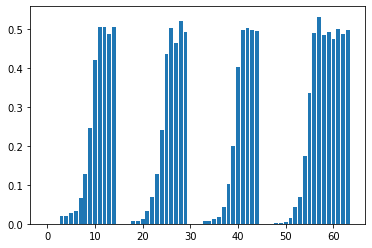

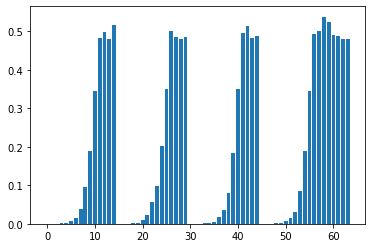

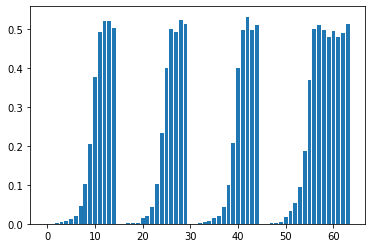

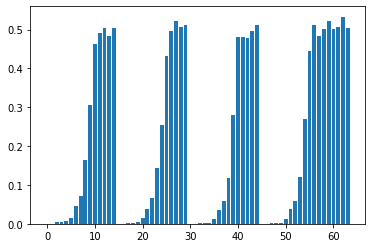

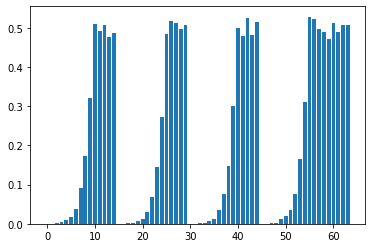

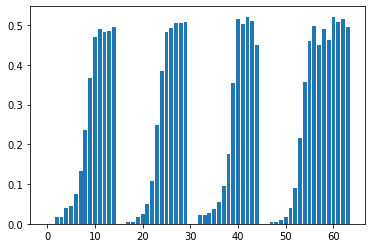

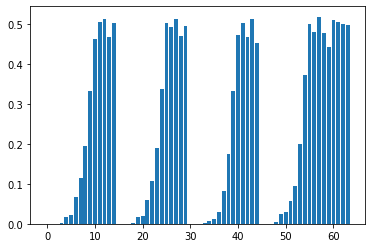

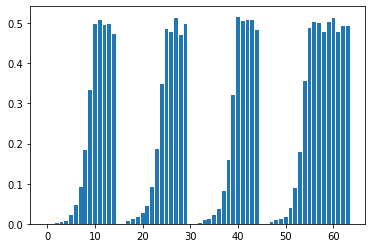

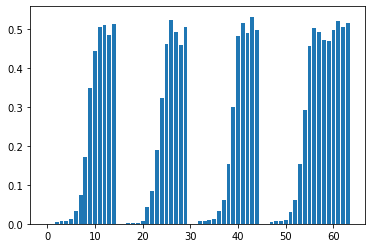

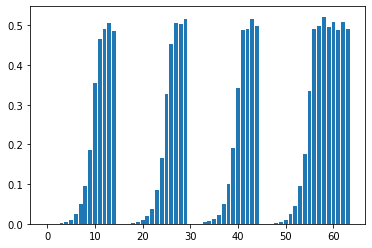

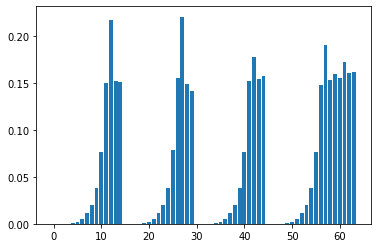

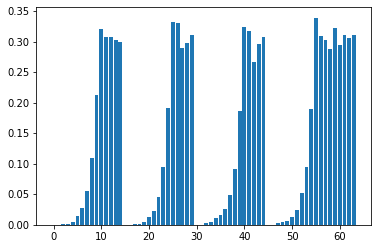

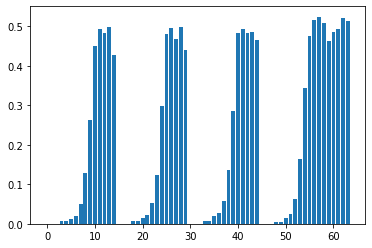

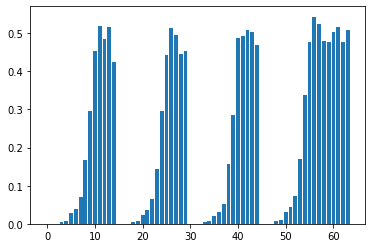

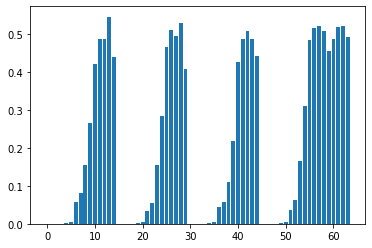

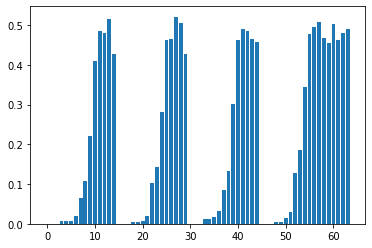

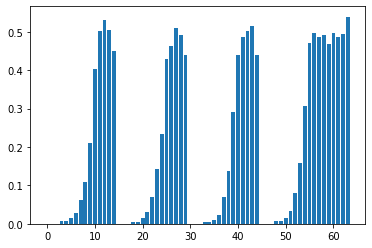

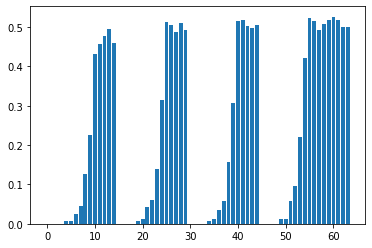

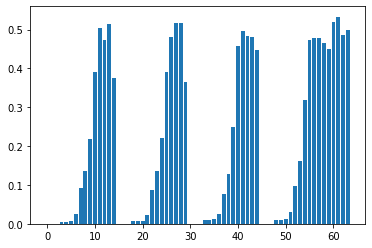

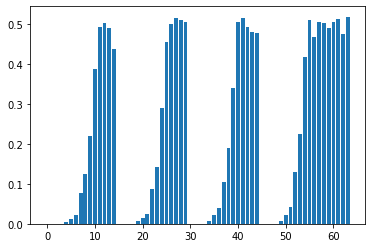

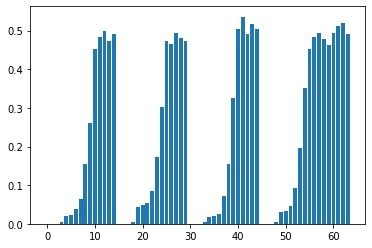

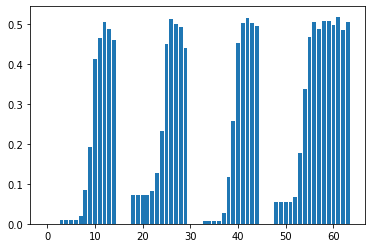

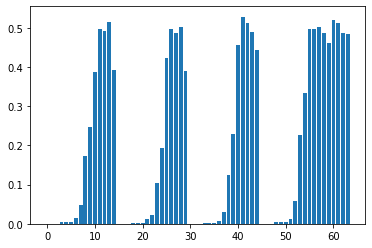

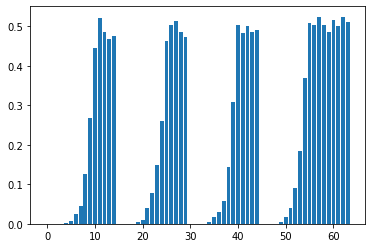

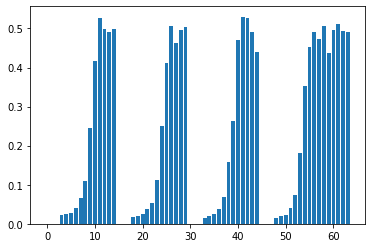

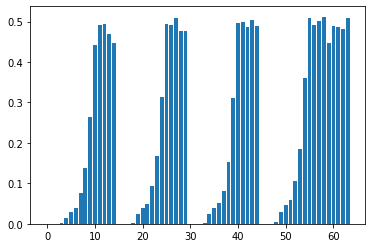

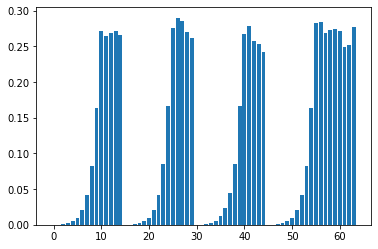

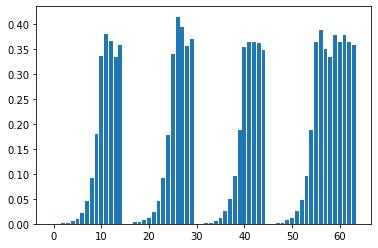

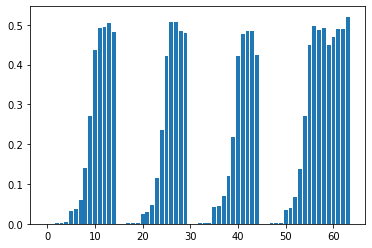

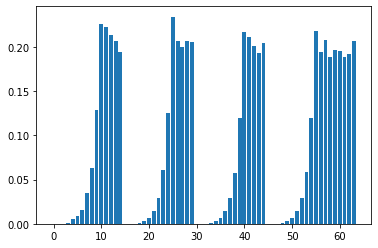

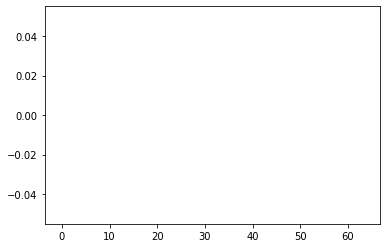

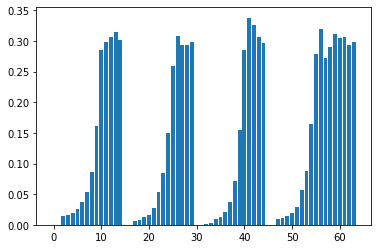

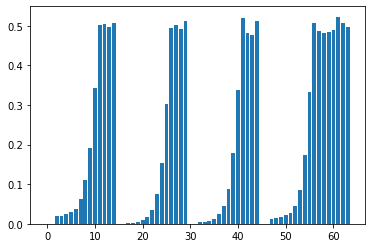

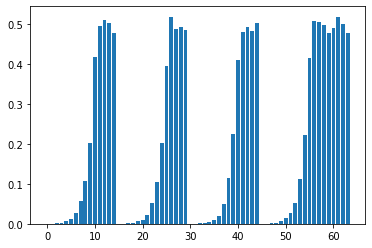

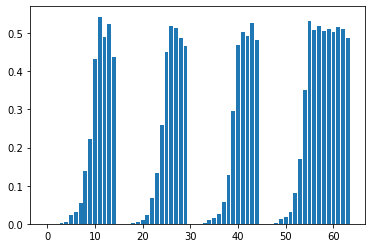

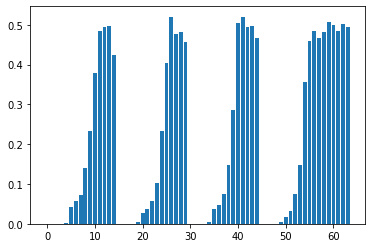

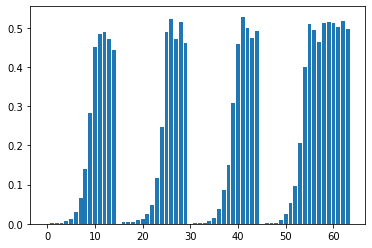

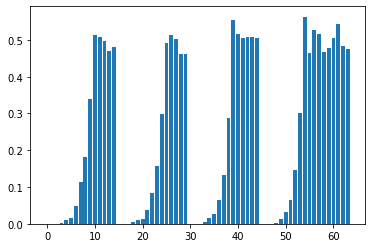

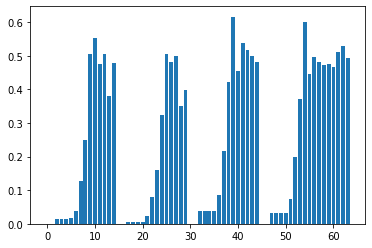

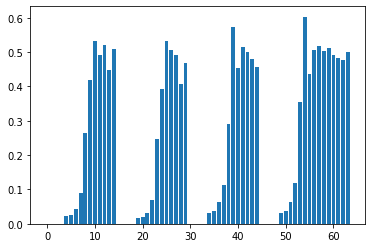

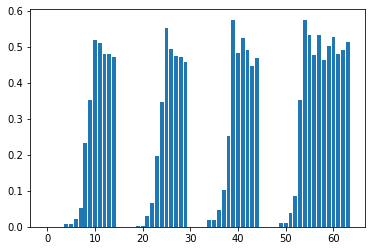

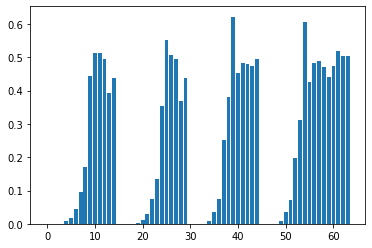

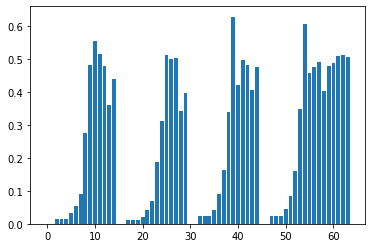

In [22]:
idname = '1d0'
messagelist = id_tracedict[idname]
length = len(id_tracedict[idname])
start = 4000
end = start + 1000
n = int((length-4000)/1000)
for i in range(n):
    messagelist = id_tracedict[idname][start: end]
    trace_len = len(messagelist)
    bit_flip = np.zeros(64)
    previous = messagelist[0]
    for item in messagelist:
        for ix in range(64):
            if item[ix] != previous[ix]:
                bit_flip[ix] = bit_flip[ix] + 1
        previous = item
    for ix in range(64):
        bit_flip[ix] = bit_flip[ix] / trace_len
    fig = plt.figure(facecolor = "white")
    plt.bar(range(len(bit_flip)), bit_flip)
    start = end
    end = end + 1000

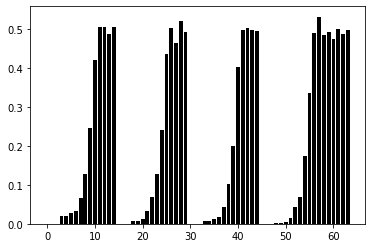

In [37]:
idname = '1d0'
messagelist = id_tracedict[idname]
length = len(id_tracedict[idname])
start = 4000
end = start + 1000
n = int((length-4000)/1000)
for i in range(n):
    messagelist = id_tracedict[idname][start: end]
    trace_len = len(messagelist)
    bit_flip = np.zeros(64)
    previous = messagelist[0]
    for item in messagelist:
        for ix in range(64):
            if item[ix] != previous[ix]:
                bit_flip[ix] = bit_flip[ix] + 1
        previous = item
    for ix in range(64):
        bit_flip[ix] = bit_flip[ix] / trace_len
    fig = plt.figure(facecolor = "white")
    plt.bar(range(len(bit_flip)), bit_flip,color="black")
    start = end
    end = end + 1000
    break

In [38]:
bit_flip

array([0.   , 0.   , 0.   , 0.019, 0.019, 0.027, 0.034, 0.066, 0.129,
       0.245, 0.422, 0.506, 0.506, 0.488, 0.506, 0.   , 0.   , 0.   ,
       0.007, 0.007, 0.013, 0.032, 0.068, 0.128, 0.241, 0.436, 0.502,
       0.464, 0.52 , 0.494, 0.   , 0.   , 0.   , 0.007, 0.007, 0.013,
       0.018, 0.044, 0.101, 0.199, 0.402, 0.497, 0.502, 0.499, 0.496,
       0.   , 0.   , 0.   , 0.001, 0.001, 0.005, 0.016, 0.042, 0.07 ,
       0.173, 0.337, 0.49 , 0.532, 0.485, 0.493, 0.475, 0.501, 0.487,
       0.497])

In [36]:
np.array(messagelist[0]).astype("int")

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0])

In [31]:
bit_flip

array([0.   , 0.   , 0.   , 0.   , 0.001, 0.005, 0.01 , 0.016, 0.026,
       0.055, 0.107, 0.185, 0.173, 0.183, 0.182, 0.   , 0.   , 0.   ,
       0.   , 0.001, 0.003, 0.008, 0.014, 0.031, 0.059, 0.122, 0.193,
       0.166, 0.204, 0.172, 0.   , 0.   , 0.   , 0.   , 0.001, 0.003,
       0.008, 0.016, 0.028, 0.057, 0.109, 0.194, 0.165, 0.167, 0.167,
       0.   , 0.   , 0.   , 0.   , 0.001, 0.003, 0.008, 0.014, 0.033,
       0.059, 0.114, 0.185, 0.182, 0.174, 0.161, 0.2  , 0.18 , 0.21 ,
       0.177])

<BarContainer object of 64 artists>

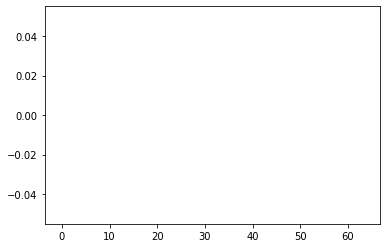

In [24]:
messagelist = id_tracedict[idname][0: 1000]
trace_len = len(messagelist)
bit_flip = np.zeros(64)
previous = messagelist[0]
for item in messagelist:
    for ix in range(64):
        if item[ix] != previous[ix]:
            bit_flip[ix] = bit_flip[ix] + 1
    previous = item
for ix in range(64):
    bit_flip[ix] = bit_flip[ix] / trace_len
fig = plt.figure(facecolor = "white")
plt.bar(range(len(bit_flip)), bit_flip)

<BarContainer object of 64 artists>

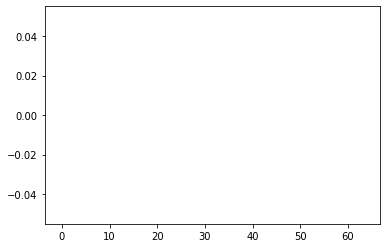

In [25]:
messagelist = id_tracedict[idname][0: 2000]
trace_len = len(messagelist)
bit_flip = np.zeros(64)
previous = messagelist[0]
for item in messagelist:
    for ix in range(64):
        if item[ix] != previous[ix]:
            bit_flip[ix] = bit_flip[ix] + 1
    previous = item
for ix in range(64):
    bit_flip[ix] = bit_flip[ix] / trace_len
fig = plt.figure(facecolor = "white")
plt.bar(range(len(bit_flip)), bit_flip)

<BarContainer object of 64 artists>

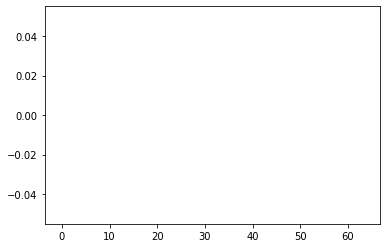

In [26]:
messagelist = id_tracedict[idname][0: 3000]
trace_len = len(messagelist)
bit_flip = np.zeros(64)
previous = messagelist[0]
for item in messagelist:
    for ix in range(64):
        if item[ix] != previous[ix]:
            bit_flip[ix] = bit_flip[ix] + 1
    previous = item
for ix in range(64):
    bit_flip[ix] = bit_flip[ix] / trace_len
fig = plt.figure(facecolor = "white")
plt.bar(range(len(bit_flip)), bit_flip)

<BarContainer object of 64 artists>

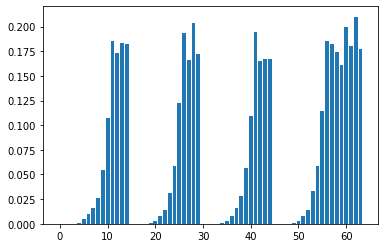

In [29]:
messagelist = id_tracedict[idname][3000: 4000]
trace_len = len(messagelist)
bit_flip = np.zeros(64)
previous = messagelist[0]
for item in messagelist:
    for ix in range(64):
        if item[ix] != previous[ix]:
            bit_flip[ix] = bit_flip[ix] + 1
    previous = item
for ix in range(64):
    bit_flip[ix] = bit_flip[ix] / trace_len
fig = plt.figure(facecolor = "white")
plt.bar(range(len(bit_flip)), bit_flip)

In [31]:
pd.DataFrame(id_tracedict_int['1d0'][4000:])

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0,0,0,0,1,1,0,0,1,0,...,1,0,1,1,1,1,0,0,0,1
1,0,0,0,0,1,1,0,0,1,0,...,1,1,0,0,1,1,0,1,1,1
2,0,0,0,0,1,1,0,0,1,0,...,1,1,0,1,0,1,1,1,1,1
3,0,0,0,0,1,1,0,0,1,0,...,1,1,1,0,1,1,0,0,1,0
4,0,0,0,0,1,1,0,0,1,0,...,1,1,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43197,0,1,1,0,0,1,1,0,0,0,...,1,0,0,1,1,1,1,1,0,0
43198,0,1,1,0,0,1,1,0,0,0,...,0,0,1,0,0,1,0,1,1,1
43199,0,1,1,0,0,1,0,1,1,1,...,0,1,1,1,0,0,1,1,1,0
43200,0,1,1,0,0,1,1,0,0,0,...,1,1,1,0,0,0,1,0,0,0


In [165]:
trace_data = []
trace_label = []
for id in id_tracedict_int.keys():
    if id == '1d0':
        break
    if(id_tracedict_int.__contains__(id) and all_id_labels.__contains__(id)):
        cur_trace = id_tracedict_int[id]
        cur_label = all_id_labels[id]
        length = len(cur_trace)
        start = 4000
        end = start + 1000
        n = int((length-4000)/1000)
        for i in range(n):
            trace_data.append(cur_trace[start: end])
            trace_label.append(cur_label)

In [166]:
trace_data_test = []
trace_label_test = []
for id in id_tracedict_int.keys():
    if id == '1d0':
        cur_trace = id_tracedict_int[id]
        cur_label = all_id_labels[id]
        length = len(cur_trace)
        start = 4000
        end = start + 1000
        n = int((length-4000)/1000)
        for i in range(n):
            trace_data_test.append(cur_trace[start: end])
            trace_label_test.append(cur_label)
            
trace_data_test = np.array(trace_data_test)
trace_label_test = np.array(trace_label_test)

In [167]:
trace_data = np.array(trace_data)
trace_label = np.array(trace_label)

In [168]:
#划分训练集测试集，取10%的测试集。
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import ShuffleSplit

ss = ShuffleSplit(n_splits=1, test_size=0.05,random_state=0)
for train_index,test_index in ss.split(trace_data):
    print('train_index', train_index, 'test_index', test_index)
    train_data, train_labels = trace_data[train_index], trace_label[train_index]
    test_data, test_labels = trace_data[test_index], trace_label[test_index]
#     train_data, train_labels = x.iloc[train_index], y.iloc[train_index]
#     test_data, test_labels = x.iloc[test_index], y.iloc[test_index]

train_index [ 65 167 199 304  45 235 233 176  76  78  15 100 350 126  52  55  54 352
 250  92 204 113  20 219 266 206 230 298 106  68  74 158 270 205 179 212
   7  64 214 159 263 226  59 101 134  56 116 246 186 164 156 196  63 299
 247 310 337 142  21 315 141  49 311 344 269 181 260 102  22 122  89 144
 132  66 261  12 120 153 289 275  17 231 324 322 225 347 103 146 191 346
 124 173 293 145 217  81   1 133   8 259 237 150 276 168 198 320 245 210
   5  33 335  34 171  97  85 278 326 348 252 162 108  46 284 175  73 137
 338 319 274  29 253 238 297 313  27 258 170 334 138 272 355 236 345  35
 221 208 224 223  44 190 129  93 111 166 240 216  18 248  79 321  71 218
 300 342 189 160 241 161  83 353 118 200 254 333 110 149 157 152  16 228
  75 109 309 325 139 349   4  96 249  61  67 283 194 154 215 303 232 332
  40 112  13 107 271   3 239 125  24  30  77 188 184 330 295 255  19 305
 307 182 317  80  51   2  11 104 264  86  10  36 339  58  41  14 155  50
 209 281 280 336 294 123 222  62 268 13

In [94]:
type(np.array(trace_data)[0])

numpy.ndarray

In [95]:
type(np.array(trace_data)[0][0])

numpy.ndarray

In [101]:
np.array(trace_data)[0][0].shape

(64,)

In [102]:
np.array(trace_data)[0].shape

(1000, 64)

In [ ]:
np.array(trace_data)

In [77]:
import random
all_data = pd.DataFrame(trace_data)
all_data['label'] = trace_label
random.shuffle(all_data)
all_data

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,label
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0

In [110]:
all_data.shape

(500, 1001)

In [78]:
all_data.shape

(500, 1001)

In [93]:
np.array(all_data.iloc[0,:1000])

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1]

In [97]:
temp = all_data.iloc[:,:1000]
temp = temp.applymap(lambda x : np.array(x))
temp.shape

(500, 1000)

In [99]:
type(np.array(temp)[0])

numpy.ndarray

In [105]:
type(np.array(temp)[0][0])

numpy.ndarray

In [109]:
np.array(temp)[0].shape

(1000,)

In [116]:
# for i in range(temp.shape[0]):
#     for j in range(temp.shape[1]):
#         temp[i][j] = np.array(temp[i][j])

In [56]:
trace_data = np.array(all_data.iloc[:,:1000].apply(lambda x : np.array(x)))
trace_label = np.array(all_data.iloc[:,-1])

In [57]:
trace_data.shape

(500, 1000)

In [30]:
# trace_data = np.concatenate(trace_data)

In [76]:
# trace_data = np.array(trace_data)
# trace_data.shape

In [32]:
# trace_data = trace_data.reshape(trace_data.shape[0], trace_data.shape[1], 1)
# trace_data.shape

In [77]:
# trace_label = np.array(trace_label)
# # trace_label = trace_label.reshape(trace_label.shape[0], 1)
# trace_label.shape

In [169]:
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, Input, Permute, BatchNormalization, Flatten, MaxPooling1D, Conv1D
from keras.losses import mean_absolute_percentage_error, mean_absolute_error
from sklearn.metrics import mean_squared_error
import keras.backend as K

#构建CNN分类模型(LeNet-5)
#模型结构：嵌入-卷积池化*2-dropout-BN-全连接-dropout-全连接
model = Sequential()
model.add(Conv1D(256, 5, padding='same', input_shape = (1000,64)))
model.add(MaxPooling1D(3, 3, padding='same'))
model.add(Conv1D(128, 5, padding='same'))
model.add(MaxPooling1D(3, 3, padding='same'))
model.add(Conv1D(64, 3, padding='same'))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(BatchNormalization())  # (批)规范化层
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# one_hot_labels = keras.utils.to_categorical(y_train, num_classes=3)  # 将标签转换为one-hot编码
model.summary()

# from keras.utils import plot_model
# #生成一个模型图，第一个参数为模型，第二个参数为要生成图片的路径及文件名，还可以指定两个参数：
# #show_shapes:指定是否显示输出数据的形状，默认为False
# #show_layer_names:指定是否显示层名称，默认为True
# plot_model(model,to_file='sentiment_analysis/model.png',show_shapes=True,show_layer_names=False)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 1000, 256)         82176     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 334, 256)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 334, 128)          163968    
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 112, 128)          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 112, 64)           24640     
_________________________________________________________________
flatten_4 (Flatten)          (None, 7168)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 7168)             

In [42]:
len(trace_data[0])

1000

In [43]:
np.array(trace_data[:-1]).shape

(499, 1000)

In [44]:
trace_label[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.])

In [45]:
trace_data.shape

(500, 1000)

In [170]:
model.fit(train_data, train_labels,epochs=5, batch_size=10)

Epoch 1/5
338/338 [==============================] - 4s 13ms/step - loss: 0.1315 - acc: 0.9433
Epoch 2/5
338/338 [==============================] - 3s 9ms/step - loss: 0.0075 - acc: 0.9976
Epoch 3/5
338/338 [==============================] - 3s 9ms/step - loss: 0.0022 - acc: 0.9992
Epoch 4/5
338/338 [==============================] - 3s 9ms/step - loss: 0.0019 - acc: 0.9994
Epoch 5/5
338/338 [==============================] - 3s 10ms/step - loss: 0.0011 - acc: 0.9997


In [171]:
test_res = model.predict(test_data)

In [172]:
import matplotlib.pylab as plt
xlabels = []
for i in range(1,65):
    xlabels.append(i)
def plot_test_res(test_res, test_label):
    plt.bar(xlabels, test_res, width=0.8, bottom=None,color="blue")
    plt.plot(xlabels, test_label, color="red")

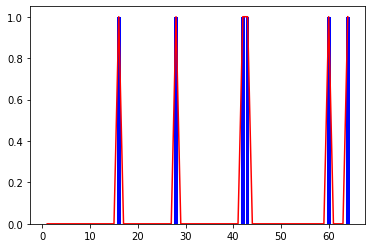

In [179]:
ix = 2
plot_test_res(test_res[ix], test_labels[ix])

In [176]:
test_res_test = model.predict(trace_data_test)

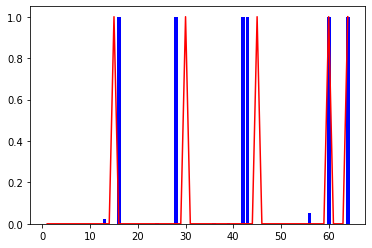

In [183]:
ix = 0
plot_test_res(test_res_test[ix], trace_label_test[ix])

In [187]:
temp_res = []
for i in range(64):
    if test_res_test[0][i]>0.5:
        temp_res.append(1)
    else:
        temp_res.append(0)

In [196]:
tempdf = pd.DataFrame(temp_res)
tempdf["label"] = trace_label_test[0]
np.array(tempdf)

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 1.],
       [1., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [1., 0.],
       [0., 0.],
       [0., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [1., 0.],
       [1., 0.],
       [0., 0.],
       [0., 1.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.

In [192]:
trace_label_test[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.])

In [126]:
0.06

0.5

In [ ]:
# y_predict = model.predict_classes(x_test_padded_seqs)  # 预测的是类别，结果就是类别号
y_predict = model.predict(x_test_padded_seqs)  # 预测的是类别，结果就是类别号
y_predict = list(map(str, y_predict))
print('准确率', metrics.accuracy_score(y_test, y_predict))
print('平均f1-score:', metrics.f1_score(y_test, y_predict, average='weighted'))

In [ ]:
model.fit(x_train_padded_seqs, one_hot_labels,epochs=5, batch_size=800)
y_predict = model.predict_classes(x_test_padded_seqs)  # 预测的是类别，结果就是类别号
y_predict = list(map(str, y_predict))
print('准确率', metrics.accuracy_score(y_test, y_predict))
print('平均f1-score:', metrics.f1_score(y_test, y_predict, average='weighted'))

In [ ]:
# train_labels = np.array(train_labels.T)[0]
# test_labels = np.array(test_labels.T)[0]

#输入数据格式为Input4，Model为LSTM
import keras
from keras.models import Model
from keras.layers import Dense, Activation, Dropout, LSTM, Input, Permute, RepeatVector, Bidirectional, Multiply, TimeDistributed
from keras.losses import mean_absolute_percentage_error, mean_absolute_error
from sklearn.metrics import mean_squared_error
import keras.backend as K
inputs = Input(shape=(1000, 64))
lstm_out = LSTM(128, return_sequences=False)(inputs)
output = Dense(64, activation="softmax")(lstm_out)
model_msb = Model(inputs=[inputs], outputs=output)
model_msb.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model_msb.summary()

In [ ]:
train_data = train_data.values.reshape(717,15,1)
K.set_value(model_msb.optimizer.lr,1e-4)
history = model_msb.fit(train_data, train_labels, epochs=20, batch_size=15, validation_split=0.1)

In [ ]:
print("训练集:")
predict_target_msb = model_msb.predict(train_data)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_msb == train_labels),len(train_labels))
print("训练集精确度等指标：")
print(metrics.classification_report(train_labels,predict_target_msb))
print("混淆矩阵：")
print(metrics.confusion_matrix(train_labels,predict_target_msb))

print("测试集:")
predict_target_test_msb =model_msb.predict(test_data)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_msb == test_labels),len(test_labels))
print("测试集精确度等指标：")
print(metrics.classification_report(test_labels,predict_target_test_msb))
print("混淆矩阵：")
print(metrics.confusion_matrix(test_labels,predict_target_test_msb))

In [29]:
ALLdata_lsb = ALLdata_lsb.fillna(0)
x_lsb = ALLdata_lsb.iloc[:,:15]
y_lsb = ALLdata_lsb.iloc[:,-1]
y_lsb = pd.DataFrame(y_lsb.tolist())

#划分训练集测试集，取10%的测试集。
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
kf = KFold(n_splits=5)
for train_index,test_index in kf.split(x_lsb):
    print('train_index', train_index, 'test_index', test_index)
    train_data, train_labels = x_lsb.iloc[train_index], y_lsb.iloc[train_index]
    test_data, test_labels = x_lsb.iloc[test_index], y_lsb.iloc[test_index]
    
train_labels = np.array(train_labels.T)[0]
test_labels = np.array(test_labels.T)[0]

#随机森林方法
from sklearn.ensemble import RandomForestClassifier
model_lsb = RandomForestClassifier(n_estimators= 30)
model_lsb.fit(train_data,train_labels)

print("训练集:")
predict_target_lsb = model_lsb.predict(train_data)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_lsb == train_labels),len(train_labels))
print("训练集精确度等指标：")
print(metrics.classification_report(train_labels,predict_target_lsb))
print("混淆矩阵：")
print(metrics.confusion_matrix(train_labels,predict_target_lsb))

print("测试集:")
predict_target_test_lsb = model_lsb.predict(test_data)
print("预测正确数量,训练集样本量:")
print(sum(predict_target_test_lsb == test_labels),len(test_labels))
print("测试集精确度等指标：")
print(metrics.classification_report(test_labels,predict_target_test_lsb))
print("混淆矩阵：")
print(metrics.confusion_matrix(test_labels,predict_target_test_lsb))

train_index [180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251
 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269
 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287
 288 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305
 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323
 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377
 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395
 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413
 414 415 416 417 418 419 420 421 422 42

训练集:
预测正确数量,训练集样本量:
687 717
训练集精确度等指标：
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       644
           1       0.98      0.60      0.75        73

    accuracy                           0.96       717
   macro avg       0.97      0.80      0.86       717
weighted avg       0.96      0.96      0.95       717

混淆矩阵：
[[643   1]
 [ 29  44]]
测试集:
预测正确数量,训练集样本量:
163 179
测试集精确度等指标：
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       162
           1       1.00      0.06      0.11        17

    accuracy                           0.91       179
   macro avg       0.96      0.53      0.53       179
weighted avg       0.92      0.91      0.87       179

混淆矩阵：
[[162   0]
 [ 16   1]]


### 4.实现Endianness优化算法，没有考虑Constant bit，针对id=1d0

In [31]:
idname = '1d0'

In [32]:
alldatas_msb_idname = []
alllabels_msb_idname = []
id = idname
if(bit_features_dict.__contains__(id) and all_id_labels.__contains__(id)):
    cur_features = bit_features_dict[id]
    cur_labels = all_id_labels[id]
    for i in range(64):
        alldatas_msb_idname.append(cur_features[i])
        alllabels_msb_idname.append(int(cur_labels[i]))
else:
    print(id)
ALLdata_msb_idname = pd.DataFrame(alldatas_msb_idname)
ALLdata_msb_idname['label'] = np.array(alllabels_msb_idname)
ALLdata_msb_idname = ALLdata_msb_idname.fillna(0)
x_msb_idname = ALLdata_msb_idname.iloc[:,:15]
y_msb_idname = ALLdata_msb_idname.iloc[:,-1]
# y_msb_idname = pd.DataFrame(y_msb_idname.tolist())

In [33]:
alldatas_lsb_idname = []
alllabels_lsb_idname = []
id = idname
if(reverse_bit_features_dict.__contains__(id) and all_id_labels.__contains__(id)):
    cur_features = reverse_bit_features_dict[id]
    cur_labels = all_id_labels[id]
    for i in range(64):
        alldatas_lsb_idname.append(cur_features[i])
        alllabels_lsb_idname.append(int(cur_labels[i]))
else:
    print(id)
ALLdata_lsb_idname = pd.DataFrame(alldatas_lsb_idname)
ALLdata_lsb_idname['label'] = np.array(alllabels_lsb_idname)
ALLdata_lsb_idname = ALLdata_lsb_idname.fillna(0)
x_lsb_idname = ALLdata_lsb_idname.iloc[:,:15]
y_lsb_idname = ALLdata_lsb_idname.iloc[:,-1]
# y_lsb_idname = pd.DataFrame(y_lsb_idname.tolist())

In [34]:
predict_msb = model_msb.predict(x_msb_idname)
predict_proba_msb = model_msb.predict_proba(x_msb_idname)
predict_proba_msb

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.96666667, 0.03333333],
       [0.96666667, 0.03333333],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.96666667, 0.03333333],
       [1.        , 0.        ],
       [0.96666667, 0.03333333],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.

In [35]:
predict_lsb = model_lsb.predict(x_lsb_idname)
predict_proba_lsb = model_lsb.predict_proba(x_lsb_idname)
predict_proba_lsb

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [0.96666667, 0.03333333],
       [0.96666667, 0.03333333],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.86666667, 0.13333333],
       [0.93333333, 0.06666667],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.83333333, 0.16666667],
       [1.        , 0.        ],
       [0.5       , 0.5       ],
       [0.96666667, 0.03333333],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.93333333, 0.06666667],
       [0.96666667, 0.03333333],
       [0.93333333, 0.06666667],
       [0.9       , 0.1       ],
       [0.96666667, 0.03333333],
       [0.96666667, 0.03333333],
       [1.        , 0.        ],
       [0.33333333, 0.66666667],
       [1.

In [36]:
predict_msb

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
      dtype=int64)

In [37]:
predict_lsb

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
      dtype=int64)

In [38]:
predictproba_lsb = []
for prediction in predict_proba_lsb:
    predictproba_lsb.append(prediction[1])
    
predictproba_msb = []
for prediction in predict_proba_msb:
    predictproba_msb.append(prediction[1])

In [39]:
ResP = pd.DataFrame(predictproba_lsb, columns=['LsbP'])
ResP['MsbP'] = predictproba_msb
ResP['label'] = y_lsb
ResP

,LsbP,MsbP,label
0,0.000000,0.000000,0
1,0.000000,0.000000,0
2,0.033333,0.000000,0
3,0.033333,0.000000,0
4,0.000000,0.000000,0
...,...,...,...
59,0.400000,0.600000,1
60,0.000000,0.066667,0
61,0.100000,0.000000,0
62,0.000000,0.033333,0


In [40]:
B = 0.6
def get_signals(predictprobas):
    signals = []
    cur_signal = []
    for lsb in predictprobas:
        cur_signal.append(lsb)
        if lsb >= B:
            signals.append(cur_signal)
            cur_signal = []
    return signals

In [41]:
lsb_signals = get_signals(predictproba_lsb)
msb_signals = get_signals(predictproba_msb)

In [42]:
pd.DataFrame(lsb_signals)

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0.0,0.000000,0.033333,0.033333,0.0,0.0,0.0,0.133333,0.066667,0.000000,...,0.066667,0.100000,0.033333,0.033333,0.000000,0.666667,NaN,NaN,NaN,NaN
1,0.0,0.066667,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.021212,0.066667,...,0.000000,0.084047,0.000000,0.000000,0.033333,0.400000,0.0,0.1,0.0,1.0


In [43]:
pd.DataFrame(msb_signals)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.033333,0.033333,1.0
1,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.033333,0.0,0.033333,0.000000,1.0
2,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,1.0
3,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.033333,0.0,0.0,0.033333,0.0,0.000000,0.000000,0.6
4,0.066667,0.0,0.033333,0.933333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
V = []
setlist1 = ['JB', 'C']
setlist2 = ['JB', 'JL', 'C']
setlist3 = ['JL', 'C']
flag = True
count = 0
for a in setlist1:
    for b in setlist2:
        for c in setlist2:
            for d in setlist2:
                for e in setlist2:
                    for f in setlist2:
                        for g in setlist2:
                            for h in setlist3:
                                v = [a,b,c,d,e,f,g,h]
                                for i in range(8):
                                    if(v[i] == 'JB' and v[i+1] == 'JL'):
                                        flag = False
                                        break
                                    if(v[i] == 'JB' and i<6 and v[i+2] == 'JL'):
                                        flag = False
                                        break
                                if flag == True:
                                    V.append(v)
                                    count = count + 1
                                flag = True

In [49]:
len(V), V

(577,
 [['JB', 'JB', 'JB', 'JB', 'JB', 'JB', 'JB', 'C'],
  ['JB', 'JB', 'JB', 'JB', 'JB', 'JB', 'C', 'C'],
  ['JB', 'JB', 'JB', 'JB', 'JB', 'C', 'JB', 'C'],
  ['JB', 'JB', 'JB', 'JB', 'JB', 'C', 'C', 'JL'],
  ['JB', 'JB', 'JB', 'JB', 'JB', 'C', 'C', 'C'],
  ['JB', 'JB', 'JB', 'JB', 'C', 'JB', 'JB', 'C'],
  ['JB', 'JB', 'JB', 'JB', 'C', 'JB', 'C', 'C'],
  ['JB', 'JB', 'JB', 'JB', 'C', 'C', 'JB', 'C'],
  ['JB', 'JB', 'JB', 'JB', 'C', 'C', 'JL', 'JL'],
  ['JB', 'JB', 'JB', 'JB', 'C', 'C', 'JL', 'C'],
  ['JB', 'JB', 'JB', 'JB', 'C', 'C', 'C', 'JL'],
  ['JB', 'JB', 'JB', 'JB', 'C', 'C', 'C', 'C'],
  ['JB', 'JB', 'JB', 'C', 'JB', 'JB', 'JB', 'C'],
  ['JB', 'JB', 'JB', 'C', 'JB', 'JB', 'C', 'C'],
  ['JB', 'JB', 'JB', 'C', 'JB', 'C', 'JB', 'C'],
  ['JB', 'JB', 'JB', 'C', 'JB', 'C', 'C', 'JL'],
  ['JB', 'JB', 'JB', 'C', 'JB', 'C', 'C', 'C'],
  ['JB', 'JB', 'JB', 'C', 'C', 'JB', 'JB', 'C'],
  ['JB', 'JB', 'JB', 'C', 'C', 'JB', 'C', 'C'],
  ['JB', 'JB', 'JB', 'C', 'C', 'JL', 'JB', 'C'],
  ['JB', 

In [54]:
E = []
for v in V:
    e = ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']
    for i in range(8):
        if v[i] == 'JB':
            e[i] = 'B'
            e[i+1] = 'B'
        if v[i] == 'JL':
            e[i] = 'L'
            e[i-1] = 'L'
    E.append(e)

In [69]:
E

[['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B'],
 ['B', 'B', 'B', 'B', 'B', 'B', 'B', 'C'],
 ['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B'],
 ['B', 'B', 'B', 'B', 'B', 'B', 'L', 'L'],
 ['B', 'B', 'B', 'B', 'B', 'B', 'C', 'C'],
 ['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B'],
 ['B', 'B', 'B', 'B', 'B', 'B', 'B', 'C'],
 ['B', 'B', 'B', 'B', 'B', 'C', 'B', 'B'],
 ['B', 'B', 'B', 'B', 'B', 'L', 'L', 'L'],
 ['B', 'B', 'B', 'B', 'B', 'L', 'L', 'C'],
 ['B', 'B', 'B', 'B', 'B', 'C', 'L', 'L'],
 ['B', 'B', 'B', 'B', 'B', 'C', 'C', 'C'],
 ['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B'],
 ['B', 'B', 'B', 'B', 'B', 'B', 'B', 'C'],
 ['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B'],
 ['B', 'B', 'B', 'B', 'B', 'B', 'L', 'L'],
 ['B', 'B', 'B', 'B', 'B', 'B', 'C', 'C'],
 ['B', 'B', 'B', 'B', 'C', 'B', 'B', 'B'],
 ['B', 'B', 'B', 'B', 'C', 'B', 'B', 'C'],
 ['B', 'B', 'B', 'B', 'L', 'L', 'B', 'B'],
 ['B', 'B', 'B', 'B', 'L', 'L', 'L', 'L'],
 ['B', 'B', 'B', 'B', 'L', 'L', 'L', 'C'],
 ['B', 'B', 'B', 'B', 'L', 'L', 'L', 'L'],
 ['B', 'B',

In [81]:
EB = pd.DataFrame(E).replace('C', 'B')
EB = np.array(EB).tolist()

In [82]:
EL = pd.DataFrame(E).replace('C', 'L')
EL = np.array(EL).tolist()

In [110]:
# 得到所有可能的信号标记集合T
def get_T(proba_msb, proba_lsb):
    T = []
    for e in EB:
        t = []
        for i in range(8):
            if e[i] == 'B':
                start = i * 8
                end = (i+1) * 8
                for j in range(start, end):
                    t.append(proba_msb[j])
            if e[i] == 'L':
                start = i * 8
                end = (i+1) * 8
                for j in range(start, end):
                    t.append(proba_lsb[j])
        T.append(t)
    for e in EL:
        t = []
        for i in range(8):
            if e[i] == 'B':
                start = i * 8
                end = (i+1) * 8
                for j in range(start, end):
                    t.append(proba_msb[j])
            if e[i] == 'L':
                start = i * 8
                end = (i+1) * 8
                for j in range(start, end):
                    t.append(proba_lsb[j])
        T.append(t)
    return T

In [111]:
T = get_T(predictproba_msb, predictproba_lsb)
B = 0.6
mint0 = []
for t in T:
    t0 = 0
    for f in t:
        t0 = t0 + min(f, B)
    mint0.append(t0)

In [112]:
tf = pd.DataFrame(T)
tf['t0'] = mint0
tf

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,t0
0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.033333,0.0,0.0,0.000000,0.6,0.066667,0.0,0.033333,0.933333,3.300000
1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.033333,0.0,0.0,0.000000,0.6,0.066667,0.0,0.033333,0.933333,3.300000
2,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.033333,0.0,0.0,0.000000,0.6,0.066667,0.0,0.033333,0.933333,3.300000
3,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.084047,0.0,0.0,0.033333,0.4,0.000000,0.1,0.000000,1.000000,3.150714
4,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.033333,0.0,0.0,0.000000,0.6,0.066667,0.0,0.033333,0.933333,3.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149,0.0,0.0,0.033333,0.033333,0.0,0.0,0.0,0.133333,0.066667,0.0,...,0.033333,0.0,0.0,0.000000,0.6,0.066667,0.0,0.033333,0.933333,4.307879
1150,0.0,0.0,0.033333,0.033333,0.0,0.0,0.0,0.133333,0.066667,0.0,...,0.084047,0.0,0.0,0.033333,0.4,0.000000,0.1,0.000000,1.000000,4.158593
1151,0.0,0.0,0.033333,0.033333,0.0,0.0,0.0,0.133333,0.066667,0.0,...,0.084047,0.0,0.0,0.033333,0.4,0.000000,0.1,0.000000,1.000000,4.158593
1152,0.0,0.0,0.033333,0.033333,0.0,0.0,0.0,0.133333,0.066667,0.0,...,0.084047,0.0,0.0,0.033333,0.4,0.000000,0.1,0.000000,1.000000,4.158593


In [113]:
res = tf[tf['t0'] == min(mint0)]
res

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,t0
578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033333,0.0,0.0,0.033333,0.4,0.0,0.1,0.0,1.0,3.133333
583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033333,0.0,0.0,0.033333,0.4,0.0,0.1,0.0,1.0,3.133333
590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033333,0.0,0.0,0.033333,0.4,0.0,0.1,0.0,1.0,3.133333
607,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033333,0.0,0.0,0.033333,0.4,0.0,0.1,0.0,1.0,3.133333
612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033333,0.0,0.0,0.033333,0.4,0.0,0.1,0.0,1.0,3.133333
648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033333,0.0,0.0,0.033333,0.4,0.0,0.1,0.0,1.0,3.133333
653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033333,0.0,0.0,0.033333,0.4,0.0,0.1,0.0,1.0,3.133333
660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033333,0.0,0.0,0.033333,0.4,0.0,0.1,0.0,1.0,3.133333


In [114]:
final_res = res.drop_duplicates()
final_res

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,t0
578,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033333,0.0,0.0,0.033333,0.4,0.0,0.1,0.0,1.0,3.133333


In [115]:
final_t = np.array(final_res)[0][:-1]
final_t

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.03333333, 0.03333333, 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.03333333, 0.        , 0.03333333, 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.03333333, 0.        , 0.        ,
       0.03333333, 0.        , 0.        , 0.03333333, 0.4       ,
       0.        , 0.1       , 0.        , 1.        ])

In [116]:
final_label = []
for i in range(64):
    if final_t[i] >= B:
        final_label.append(i)
final_label

[14, 29, 44, 63]

In [117]:
all_id_lsbs['1d0']

[14, 29, 44, 59, 63]

### 5.实现Endianness优化算法，没有考虑Constant bit

In [ ]:
alldatas_msb_idname = []
alllabels_msb_idname = []
id = idname
if(bit_features_dict.__contains__(id) and all_id_labels.__contains__(id)):
    cur_features = bit_features_dict[id]
    cur_labels = all_id_labels[id]
    for i in range(64):
        alldatas_msb_idname.append(cur_features[i])
        alllabels_msb_idname.append(int(cur_labels[i]))
else:
    print(id)
ALLdata_msb_idname = pd.DataFrame(alldatas_msb_idname)
ALLdata_msb_idname['label'] = np.array(alllabels_msb_idname)
ALLdata_msb_idname = ALLdata_msb_idname.fillna(0)
x_msb_idname = ALLdata_msb_idname.iloc[:,:15]
y_msb_idname = ALLdata_msb_idname.iloc[:,-1]

In [ ]:
alldatas_lsb_idname = []
alllabels_lsb_idname = []
id = idname
if(reverse_bit_features_dict.__contains__(id) and all_id_labels.__contains__(id)):
    cur_features = reverse_bit_features_dict[id]
    cur_labels = all_id_labels[id]
    for i in range(64):
        alldatas_lsb_idname.append(cur_features[i])
        alllabels_lsb_idname.append(int(cur_labels[i]))
else:
    print(id)
ALLdata_lsb_idname = pd.DataFrame(alldatas_lsb_idname)
ALLdata_lsb_idname['label'] = np.array(alllabels_lsb_idname)
ALLdata_lsb_idname = ALLdata_lsb_idname.fillna(0)
x_lsb_idname = ALLdata_lsb_idname.iloc[:,:15]
y_lsb_idname = ALLdata_lsb_idname.iloc[:,-1]
# y_lsb_idname = pd.DataFrame(y_lsb_idname.tolist())

In [120]:
alldatas_msb_dict = {}
# alllabels_msb_dict = {}
# cur_alldatas_msb = []
# cur_alllabels_msb = []
for id in bit_features_dict.keys():
    if(bit_features_dict.__contains__(id) and all_id_labels.__contains__(id)):
        cur_features = bit_features_dict[id]
#         cur_labels = all_id_labels[id]
#         for i in range(64):
#             cur_alldatas_msb.append(cur_features[i])
# #             cur_alllabels_msb.append(int(cur_labels[i]))
    else:
        print(id)
    cur_features = pd.DataFrame(cur_features).fillna(0)
    alldatas_msb_dict[id] = cur_features

13c
156
161
18e
19b
1a6
1aa
1dc
1ed
21e
294
295
320
328
372
377
378
386
39
3d7
3d9
400
403
406
40c
40f
428
42d
42e
454
465
555
91


In [121]:
alldatas_lsb_dict = {}
# alllabels_msb_dict = {}
# cur_alldatas_msb = []
# cur_alllabels_msb = []
for id in bit_features_dict.keys():
    if(reverse_bit_features_dict.__contains__(id) and all_id_labels.__contains__(id)):
        cur_features = reverse_bit_features_dict[id]
#         cur_labels = all_id_labels[id]
#         for i in range(64):
#             cur_alldatas_msb.append(cur_features[i])
#             cur_alllabels_msb.append(int(cur_labels[i]))
    else:
        print(id)
    cur_features = pd.DataFrame(cur_features).fillna(0)
    alldatas_lsb_dict[id] = cur_features

13c
156
161
18e
19b
1a6
1aa
1dc
1ed
21e
294
295
320
328
372
377
378
386
39
3d7
3d9
400
403
406
40c
40f
428
42d
42e
454
465
555
91


In [130]:
predict_proba_msb_dict = {}
for id in alldatas_msb_dict.keys():
    cur_predictproba_msb = []
    cur_predict_proba_msb = model_msb.predict_proba(alldatas_msb_dict[id])
    for prediction in cur_predict_proba_msb:
        cur_predictproba_msb.append(prediction[1])
    predict_proba_msb_dict[id] = cur_predictproba_msb
    
predict_proba_lsb_dict = {}
for id in alldatas_lsb_dict.keys():
    cur_predictproba_lsb = []
    cur_predict_proba_lsb = model_lsb.predict_proba(alldatas_lsb_dict[id])
    for prediction in cur_predict_proba_lsb:
        cur_predictproba_lsb.append(prediction[1])
    predict_proba_lsb_dict[id] = cur_predictproba_lsb

In [132]:
B = 0.6
final_label_dict = {}
for id in predict_proba_msb_dict.keys():
    curT = get_T(predict_proba_msb_dict[id], predict_proba_lsb_dict[id])
    mint0 = []
    for t in curT:
        t0 = 0
        for f in t:
            t0 = t0 + min(f, B)
        mint0.append(t0)
    tf = pd.DataFrame(curT)
    tf['t0'] = mint0
    res = tf[tf['t0'] == min(mint0)]
    final_res = res.drop_duplicates()
    final_t = np.array(final_res)[0][:-1]
    final_label = []
    for i in range(64):
        if final_t[i] >= B:
            final_label.append(i)
    final_label_dict[id] = final_label

In [133]:
final_label_dict['1d0']

[14, 29, 44, 63]

In [135]:
all_id_lsbs['1d0']

[14, 29, 44, 59, 63]

In [137]:
for id in final_label_dict.keys():
    if(final_label_dict.__contains__(id) and all_id_lsbs.__contains__(id)):
        print(final_label_dict[id])
        print(all_id_lsbs[id])
        print("------------------------------------------")

[15, 47, 55, 59, 63]
[15, 31, 47, 55, 59, 63]
------------------------------------------
[7, 31, 32, 38, 39, 49, 50, 59, 63]
[7, 31, 32, 33, 38, 39, 49, 50, 55, 59, 63]
------------------------------------------
[7, 31, 39, 63]
[7, 47, 31, 39, 41, 59, 63]
------------------------------------------
[15, 63]
[27, 15, 41, 42, 59, 63]
------------------------------------------
[]
[11, 12, 14, 51, 55]
------------------------------------------
[14, 29, 44, 63]
[14, 29, 44, 59, 63]
------------------------------------------
[15, 31, 59, 63]
[15, 31, 59, 63]
------------------------------------------
[]
[16, 35, 43, 47]
------------------------------------------
[7, 15, 23, 31, 47, 55, 63]
[7, 15, 23, 31, 39, 47, 55, 63, 59]
------------------------------------------
[0]
[0, 13, 12, 11, 10, 9, 8, 51, 55]
------------------------------------------
[15, 23, 31, 47, 49, 59, 63]
[23, 15, 47, 31, 49, 59, 63]
------------------------------------------
[47, 63]
[31, 59, 63]
-------------------------